# Imports

In [25]:
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import numpy as np
%matplotlib inline

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc

In [5]:
from catboost import CatBoostClassifier
from catboost import Pool, cv
import optuna
import pandas_profiling as pp

# Load Data

In [6]:
train = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')

In [7]:
labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

In [8]:
num_cols = train.select_dtypes('number').columns

In [9]:
cat_cols = ['race', 'sex', 'marital_status', 'rent_or_own',  'hhs_geo_region','census_msa', 'employment_industry', 'employment_occupation']

In [10]:
ord_cols = ['age_group', 'education',  'income_poverty','employment_status']

# Cleaning Data

In [11]:
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [12]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

In [44]:
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

In [45]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

# Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, random_state=10)

# Optuna Optimization with Cross Validation

In [14]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34], dtype=int64)

In [15]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

### H1N1 Vaccine

In [16]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree']),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': 'Logloss',
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=True, verbose=False)

    return scores['test-AUC-mean'].max()

In [53]:
sampler = optuna.samplers.TPESampler(seed=68)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-01-26 14:54:40,287] A new study created in memory with name: no-name-b2973642-f79c-43bc-b257-5d14a8bfae7e


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4624059674
bestIteration = 127

Training on fold [1/5]

bestTest = 0.4775285429
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4668221764
bestIteration = 152

Training on fold [3/5]

bestTest = 0.4690573884
bestIteration = 108

Training on fold [4/5]


[I 2022-01-26 14:55:23,780] Trial 0 finished with value: 0.8612385183893709 and parameters: {'iterations': 1500, 'learning_rate': 0.08961999953042239, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0011812125446097113, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8612385183893709.



bestTest = 0.4508873272
bestIteration = 167



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.459367151
bestIteration = 78

Training on fold [1/5]

bestTest = 0.4672221176
bestIteration = 85

Training on fold [2/5]

bestTest = 0.4627921364
bestIteration = 72

Training on fold [3/5]

bestTest = 0.4569278772
bestIteration = 117

Training on fold [4/5]


[I 2022-01-26 14:55:26,183] Trial 1 finished with value: 0.8644927244952644 and parameters: {'iterations': 1000, 'learning_rate': 0.2957047309441607, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.001354720669824658, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8644927244952644.



bestTest = 0.4510511681
bestIteration = 108



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4609578114
bestIteration = 178

Training on fold [1/5]

bestTest = 0.4665927869
bestIteration = 246

Training on fold [2/5]

bestTest = 0.460579581
bestIteration = 205

Training on fold [3/5]

bestTest = 0.455257906
bestIteration = 284

Training on fold [4/5]


[I 2022-01-26 14:55:31,247] Trial 2 finished with value: 0.8653443572136345 and parameters: {'iterations': 1200, 'learning_rate': 0.1371525795360902, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.0048185425547954824, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.449651354
bestIteration = 225



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4939262136
bestIteration = 102

Training on fold [1/5]

bestTest = 0.5020594822
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4873110976
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5016280756
bestIteration = 118

Training on fold [4/5]


[I 2022-01-26 14:56:21,016] Trial 3 finished with value: 0.8479749358772916 and parameters: {'iterations': 300, 'learning_rate': 0.026623822549052163, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 1.9008463722440555e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.4912932762
bestIteration = 129



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4679420296
bestIteration = 869

Training on fold [1/5]

bestTest = 0.4768177701
bestIteration = 999

Training on fold [2/5]

bestTest = 0.471796305
bestIteration = 905

Training on fold [3/5]

bestTest = 0.4690560757
bestIteration = 999

Training on fold [4/5]

bestTest = 0.459017201
bestIteration = 999



[I 2022-01-26 14:56:56,319] Trial 4 finished with value: 0.8615670251294348 and parameters: {'iterations': 1000, 'learning_rate': 0.007101034052723374, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.005827202489296445, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4592573359
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4679461033
bestIteration = 77

Training on fold [2/5]

bestTest = 0.4623240356
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4566058998
bestIteration = 96

Training on fold [4/5]


[I 2022-01-26 14:56:58,587] Trial 5 finished with value: 0.8646097366870045 and parameters: {'iterations': 1500, 'learning_rate': 0.2964430813582234, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 1.7622702261668875e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.4464591106
bestIteration = 137



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560488489
bestIteration = 54

Training on fold [1/5]

bestTest = 0.4651861607
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4527406763
bestIteration = 66

Training on fold [3/5]

bestTest = 0.450974487
bestIteration = 79

Training on fold [4/5]


[I 2022-01-26 14:57:21,715] Trial 6 finished with value: 0.86833548032738 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 23.41661191676168, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4430639459
bestIteration = 66



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5222214319
bestIteration = 16

Training on fold [1/5]

bestTest = 0.5450952267
bestIteration = 12

Training on fold [2/5]

bestTest = 0.5172339306
bestIteration = 18

Training on fold [3/5]

bestTest = 0.5255905034
bestIteration = 17

Training on fold [4/5]


[I 2022-01-26 14:57:23,805] Trial 7 finished with value: 0.825964607314283 and parameters: {'iterations': 1500, 'learning_rate': 0.1253699635699981, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.8307160689696775e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.5122508569
bestIteration = 16



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4904258385
bestIteration = 150

Training on fold [1/5]

bestTest = 0.501588308
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4895621869
bestIteration = 157

Training on fold [3/5]

bestTest = 0.4906704986
bestIteration = 162

Training on fold [4/5]


[I 2022-01-26 14:57:37,146] Trial 8 finished with value: 0.8507894843105575 and parameters: {'iterations': 1000, 'learning_rate': 0.00957473821190967, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0003332900472045444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4749435184
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5248115503
bestIteration = 6

Training on fold [1/5]

bestTest = 0.5268995245
bestIteration = 4

Training on fold [2/5]

bestTest = 0.5169204735
bestIteration = 4

Training on fold [3/5]

bestTest = 0.516185756
bestIteration = 6

Training on fold [4/5]


[I 2022-01-26 14:57:38,596] Trial 9 finished with value: 0.830463934521644 and parameters: {'iterations': 1000, 'learning_rate': 0.2301364835144914, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0013398579507442577, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.5067246816
bestIteration = 6



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548207501
bestIteration = 95

Training on fold [1/5]

bestTest = 0.460718278
bestIteration = 114

Training on fold [2/5]

bestTest = 0.451866767
bestIteration = 121

Training on fold [3/5]

bestTest = 0.4561457492
bestIteration = 94

Training on fold [4/5]


[I 2022-01-26 14:57:57,684] Trial 10 finished with value: 0.8682748175087112 and parameters: {'iterations': 300, 'learning_rate': 0.21210578031115196, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4459647329
bestIteration = 94



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4547663993
bestIteration = 109

Training on fold [1/5]

bestTest = 0.4627484234
bestIteration = 111

Training on fold [2/5]

bestTest = 0.4518510571
bestIteration = 115

Training on fold [3/5]

bestTest = 0.4543600222
bestIteration = 90

Training on fold [4/5]


[I 2022-01-26 14:58:17,956] Trial 11 finished with value: 0.8682894916311558 and parameters: {'iterations': 300, 'learning_rate': 0.21179272225527906, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 34.56103765349822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4438105499
bestIteration = 126



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4546200472
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4623714815
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4532286823
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4531781703
bestIteration = 102

Training on fold [4/5]


[I 2022-01-26 14:58:36,989] Trial 12 finished with value: 0.8680021596352823 and parameters: {'iterations': 300, 'learning_rate': 0.21371183387618528, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 95.0310408809215, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4462684924
bestIteration = 104



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4633551629
bestIteration = 36

Training on fold [1/5]

bestTest = 0.4738903918
bestIteration = 56

Training on fold [2/5]

bestTest = 0.461675979
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4695266004
bestIteration = 40

Training on fold [4/5]


[I 2022-01-26 14:59:01,034] Trial 13 finished with value: 0.861533275577447 and parameters: {'iterations': 500, 'learning_rate': 0.19045086165750252, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.8236334555490133, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4544806938
bestIteration = 52



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4594321445
bestIteration = 56

Training on fold [1/5]

bestTest = 0.4628819753
bestIteration = 116

Training on fold [2/5]

bestTest = 0.4569692217
bestIteration = 64

Training on fold [3/5]

bestTest = 0.4555857316
bestIteration = 81

Training on fold [4/5]


[I 2022-01-26 14:59:15,861] Trial 14 finished with value: 0.8663457429675621 and parameters: {'iterations': 300, 'learning_rate': 0.24917216994779037, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.7466656179671237, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4467341806
bestIteration = 70



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4612849473
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4678233458
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4572725541
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4603862167
bestIteration = 61

Training on fold [4/5]


[I 2022-01-26 14:59:44,736] Trial 15 finished with value: 0.865081408654486 and parameters: {'iterations': 300, 'learning_rate': 0.1739341400194549, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.8549315771643822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4481103969
bestIteration = 74



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4556062509
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4622056764
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4579888095
bestIteration = 54

Training on fold [3/5]

bestTest = 0.4554969837
bestIteration = 51

Training on fold [4/5]


[I 2022-01-26 15:00:01,311] Trial 16 finished with value: 0.8671270255327341 and parameters: {'iterations': 1200, 'learning_rate': 0.26053855113572677, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 6.429309779261425, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4462674534
bestIteration = 65



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4750217257
bestIteration = 27

Training on fold [1/5]

bestTest = 0.4833010346
bestIteration = 40

Training on fold [2/5]

bestTest = 0.4722182847
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4773769106
bestIteration = 48

Training on fold [4/5]


[I 2022-01-26 15:00:22,395] Trial 17 finished with value: 0.8542758128566789 and parameters: {'iterations': 500, 'learning_rate': 0.162290906081111, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.06306159710746394, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.468587619
bestIteration = 31



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4596113792
bestIteration = 191

Training on fold [1/5]

bestTest = 0.4642100854
bestIteration = 242

Training on fold [2/5]

bestTest = 0.4570876374
bestIteration = 275

Training on fold [3/5]

bestTest = 0.4574158365
bestIteration = 214

Training on fold [4/5]


[I 2022-01-26 15:00:28,196] Trial 18 finished with value: 0.8659593007553548 and parameters: {'iterations': 300, 'learning_rate': 0.08253977991457023, 'random_strength': 7, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 2.8479737297402608e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4506592319
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.454352057
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4651791855
bestIteration = 50

Training on fold [2/5]

bestTest = 0.4549420499
bestIteration = 72

Training on fold [3/5]

bestTest = 0.4519337441
bestIteration = 73

Training on fold [4/5]


[I 2022-01-26 15:00:47,421] Trial 19 finished with value: 0.8671474793762928 and parameters: {'iterations': 300, 'learning_rate': 0.2621547368672365, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 10.225320123105696, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4465499557
bestIteration = 81



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4668955947
bestIteration = 47

Training on fold [1/5]

bestTest = 0.4725374891
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4710617396
bestIteration = 60

Training on fold [3/5]

bestTest = 0.466821774
bestIteration = 56

Training on fold [4/5]


[I 2022-01-26 15:01:12,275] Trial 20 finished with value: 0.859570490685557 and parameters: {'iterations': 300, 'learning_rate': 0.19280316585525661, 'random_strength': 7, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.06889212297158703, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4568255715
bestIteration = 63



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560042616
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4615313839
bestIteration = 107

Training on fold [2/5]

bestTest = 0.45191141
bestIteration = 125

Training on fold [3/5]

bestTest = 0.4549006457
bestIteration = 73

Training on fold [4/5]


[I 2022-01-26 15:01:32,155] Trial 21 finished with value: 0.8681165045015546 and parameters: {'iterations': 300, 'learning_rate': 0.21082492056123503, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 64.54115703707609, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4452026642
bestIteration = 119



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4549004515
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4680499604
bestIteration = 58

Training on fold [2/5]

bestTest = 0.4538510977
bestIteration = 64

Training on fold [3/5]

bestTest = 0.4535899907
bestIteration = 68

Training on fold [4/5]


[I 2022-01-26 15:01:51,961] Trial 22 finished with value: 0.867188633358564 and parameters: {'iterations': 300, 'learning_rate': 0.23551124364277715, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 17.4112617465734, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4429296595
bestIteration = 96



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4537640962
bestIteration = 137

Training on fold [1/5]

bestTest = 0.465720639
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4561693594
bestIteration = 103

Training on fold [3/5]

bestTest = 0.4567465798
bestIteration = 89

Training on fold [4/5]


[I 2022-01-26 15:02:08,867] Trial 23 finished with value: 0.8670654235871327 and parameters: {'iterations': 300, 'learning_rate': 0.20644541534625796, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 3.7174919929890318, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4459062557
bestIteration = 125



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4577440893
bestIteration = 58

Training on fold [1/5]

bestTest = 0.4699738318
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4581649119
bestIteration = 69

Training on fold [3/5]

bestTest = 0.4559630557
bestIteration = 81

Training on fold [4/5]


[I 2022-01-26 15:02:20,821] Trial 24 finished with value: 0.8657928842815806 and parameters: {'iterations': 500, 'learning_rate': 0.2748235218781543, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.1444419042507601, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4443613163
bestIteration = 133



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548014019
bestIteration = 102

Training on fold [1/5]

bestTest = 0.466194199
bestIteration = 95

Training on fold [2/5]

bestTest = 0.4530714897
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4549644066
bestIteration = 94

Training on fold [4/5]


[I 2022-01-26 15:02:46,276] Trial 25 finished with value: 0.8674981979173493 and parameters: {'iterations': 1200, 'learning_rate': 0.22942372750746504, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 91.73489550576943, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4442731447
bestIteration = 90



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4607686478
bestIteration = 44

Training on fold [1/5]

bestTest = 0.4735672047
bestIteration = 41

Training on fold [2/5]

bestTest = 0.456813536
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4600268117
bestIteration = 39

Training on fold [4/5]


[I 2022-01-26 15:03:08,860] Trial 26 finished with value: 0.8634044391769322 and parameters: {'iterations': 300, 'learning_rate': 0.17915933563789485, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.9974048457037377, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4532801501
bestIteration = 62



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4564108104
bestIteration = 103

Training on fold [1/5]

bestTest = 0.4611165447
bestIteration = 115

Training on fold [2/5]

bestTest = 0.4532960358
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4534980435
bestIteration = 91

Training on fold [4/5]


[I 2022-01-26 15:03:39,679] Trial 27 finished with value: 0.8682983179173618 and parameters: {'iterations': 300, 'learning_rate': 0.1525974170025792, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 19.945758595783783, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4441361047
bestIteration = 101



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4856971419
bestIteration = 34

Training on fold [1/5]

bestTest = 0.5009984742
bestIteration = 41

Training on fold [2/5]

bestTest = 0.4884388434
bestIteration = 36

Training on fold [3/5]

bestTest = 0.495553855
bestIteration = 31

Training on fold [4/5]


[I 2022-01-26 15:03:58,706] Trial 28 finished with value: 0.8470682777402434 and parameters: {'iterations': 300, 'learning_rate': 0.10886755228639378, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 1.0595003544247859e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4864372751
bestIteration = 19



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4586023091
bestIteration = 163

Training on fold [1/5]

bestTest = 0.4681910953
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4554000488
bestIteration = 188

Training on fold [3/5]

bestTest = 0.4621193693
bestIteration = 180

Training on fold [4/5]


[I 2022-01-26 15:04:53,348] Trial 29 finished with value: 0.8654828486539197 and parameters: {'iterations': 1500, 'learning_rate': 0.07630394021032791, 'random_strength': 8, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.11165438757877619, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4486036027
bestIteration = 213



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4552154764
bestIteration = 72

Training on fold [1/5]

bestTest = 0.466595075
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4534960141
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4566691081
bestIteration = 83

Training on fold [4/5]


[I 2022-01-26 15:05:19,952] Trial 30 finished with value: 0.8670336711075939 and parameters: {'iterations': 300, 'learning_rate': 0.16384258263443902, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 21.517112181063595, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.445178288
bestIteration = 88



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4527643904
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4654314989
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4519697864
bestIteration = 139

Training on fold [3/5]

bestTest = 0.4533394224
bestIteration = 114

Training on fold [4/5]


[I 2022-01-26 15:05:42,426] Trial 31 finished with value: 0.868623387977953 and parameters: {'iterations': 300, 'learning_rate': 0.15327526907128053, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 18.829147866534395, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4430726967
bestIteration = 145



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4577466849
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4615679804
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4536579219
bestIteration = 117

Training on fold [3/5]

bestTest = 0.4557918218
bestIteration = 99

Training on fold [4/5]


[I 2022-01-26 15:05:46,556] Trial 32 finished with value: 0.8678891954762836 and parameters: {'iterations': 300, 'learning_rate': 0.15047499795280334, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 17.237859843399594, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4429327391
bestIteration = 146



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4624645836
bestIteration = 77

Training on fold [1/5]

bestTest = 0.4724219904
bestIteration = 69

Training on fold [2/5]

bestTest = 0.4626517037
bestIteration = 80

Training on fold [3/5]

bestTest = 0.4631117118
bestIteration = 99

Training on fold [4/5]


[I 2022-01-26 15:06:20,883] Trial 33 finished with value: 0.862549984085285 and parameters: {'iterations': 300, 'learning_rate': 0.11851248520978816, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.3545828548311504, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4564283853
bestIteration = 82



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4544873734
bestIteration = 159

Training on fold [1/5]

bestTest = 0.4647863089
bestIteration = 148

Training on fold [2/5]

bestTest = 0.4574013088
bestIteration = 137

Training on fold [3/5]

bestTest = 0.4582451989
bestIteration = 141

Training on fold [4/5]


[I 2022-01-26 15:06:26,965] Trial 34 finished with value: 0.8668699208349899 and parameters: {'iterations': 1200, 'learning_rate': 0.10279586303682202, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 3.149837766613654, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4462076871
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4588609533
bestIteration = 119

Training on fold [1/5]

bestTest = 0.4650155187
bestIteration = 147

Training on fold [2/5]

bestTest = 0.4604974702
bestIteration = 127

Training on fold [3/5]

bestTest = 0.4563509413
bestIteration = 138

Training on fold [4/5]


[I 2022-01-26 15:06:30,615] Trial 35 finished with value: 0.8658023675547728 and parameters: {'iterations': 300, 'learning_rate': 0.1491570806594793, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.01471940580521533, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4485632728
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.45576501
bestIteration = 241

Training on fold [1/5]

bestTest = 0.4652309276
bestIteration = 222

Training on fold [2/5]

bestTest = 0.4523320283
bestIteration = 234

Training on fold [3/5]

bestTest = 0.4514290013
bestIteration = 240

Training on fold [4/5]


[I 2022-01-26 15:08:29,847] Trial 36 finished with value: 0.8691179999511197 and parameters: {'iterations': 1500, 'learning_rate': 0.05782509318844685, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 19.59519475239158, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4432348434
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.456756076
bestIteration = 219

Training on fold [1/5]

bestTest = 0.4691437706
bestIteration = 201

Training on fold [2/5]

bestTest = 0.4531525201
bestIteration = 228

Training on fold [3/5]

bestTest = 0.4599414115
bestIteration = 158

Training on fold [4/5]


[I 2022-01-26 15:10:14,626] Trial 37 finished with value: 0.8664077366278718 and parameters: {'iterations': 1500, 'learning_rate': 0.049381272672382556, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 4.949898948021792, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4520018394
bestIteration = 174



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4754187609
bestIteration = 109

Training on fold [1/5]

bestTest = 0.4927614569
bestIteration = 79

Training on fold [2/5]

bestTest = 0.4857874896
bestIteration = 72

Training on fold [3/5]

bestTest = 0.489158783
bestIteration = 58

Training on fold [4/5]


[I 2022-01-26 15:11:00,029] Trial 38 finished with value: 0.8509611808821095 and parameters: {'iterations': 1500, 'learning_rate': 0.058746124286410926, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0.00020837494437933067, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4816807591
bestIteration = 97



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4799728533
bestIteration = 27

Training on fold [1/5]

bestTest = 0.5021150283
bestIteration = 28

Training on fold [2/5]

bestTest = 0.4886581964
bestIteration = 35

Training on fold [3/5]

bestTest = 0.4915700797
bestIteration = 36

Training on fold [4/5]


[I 2022-01-26 15:11:02,903] Trial 39 finished with value: 0.8465715359891129 and parameters: {'iterations': 1500, 'learning_rate': 0.13681596355727818, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0.01681741846683415, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4794646898
bestIteration = 42



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4602236612
bestIteration = 944

Training on fold [1/5]

bestTest = 0.467833909
bestIteration = 998

Training on fold [2/5]

bestTest = 0.4619646081
bestIteration = 904

Training on fold [3/5]

bestTest = 0.4601061347
bestIteration = 996

Training on fold [4/5]

bestTest = 0.4519712318
bestIteration = 998



[I 2022-01-26 15:11:26,988] Trial 40 finished with value: 0.8649900842939479 and parameters: {'iterations': 1000, 'learning_rate': 0.025508535042355132, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.329955338437481, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539199127
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4642611313
bestIteration = 105

Training on fold [2/5]

bestTest = 0.451271339
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4517245683
bestIteration = 123

Training on fold [4/5]


[I 2022-01-26 15:12:11,115] Trial 41 finished with value: 0.8689625262349423 and parameters: {'iterations': 1500, 'learning_rate': 0.13124379928420676, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 21.460778100104363, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4413975975
bestIteration = 166



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4550147302
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4632797129
bestIteration = 152

Training on fold [2/5]

bestTest = 0.4529987218
bestIteration = 189

Training on fold [3/5]

bestTest = 0.4533216015
bestIteration = 159

Training on fold [4/5]


[I 2022-01-26 15:13:02,283] Trial 42 finished with value: 0.8685208738740027 and parameters: {'iterations': 1500, 'learning_rate': 0.09369107780601738, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 1.6899148706207925, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.44336942
bestIteration = 150



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560444914
bestIteration = 197

Training on fold [1/5]

bestTest = 0.468288747
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4539409115
bestIteration = 220

Training on fold [3/5]

bestTest = 0.4587027564
bestIteration = 189

Training on fold [4/5]


[I 2022-01-26 15:14:27,362] Trial 43 finished with value: 0.8668700030967557 and parameters: {'iterations': 1500, 'learning_rate': 0.06331053727900046, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.900786593243464, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4455519214
bestIteration = 210



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4561156642
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4627068958
bestIteration = 142

Training on fold [2/5]

bestTest = 0.4544523417
bestIteration = 154

Training on fold [3/5]

bestTest = 0.4529164051
bestIteration = 169

Training on fold [4/5]


[I 2022-01-26 15:15:22,874] Trial 44 finished with value: 0.8682950536828071 and parameters: {'iterations': 1500, 'learning_rate': 0.09636096888970697, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 8.679226567154252, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4437425227
bestIteration = 174



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4516850731
bestIteration = 354

Training on fold [1/5]

bestTest = 0.4677607241
bestIteration = 321

Training on fold [2/5]

bestTest = 0.4522586981
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4534826906
bestIteration = 364

Training on fold [4/5]


[I 2022-01-26 15:18:11,199] Trial 45 finished with value: 0.8690915529098812 and parameters: {'iterations': 1500, 'learning_rate': 0.040137316359271646, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 31.863165241478427, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4413194696
bestIteration = 402



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4524000625
bestIteration = 368

Training on fold [1/5]

bestTest = 0.4665751252
bestIteration = 363

Training on fold [2/5]

bestTest = 0.4511078695
bestIteration = 442

Training on fold [3/5]

bestTest = 0.4535432973
bestIteration = 426

Training on fold [4/5]


[I 2022-01-26 15:21:42,206] Trial 46 finished with value: 0.8688896879260024 and parameters: {'iterations': 1500, 'learning_rate': 0.03695669381593769, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 47.39666877667559, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4439874736
bestIteration = 395



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4513168211
bestIteration = 530

Training on fold [1/5]

bestTest = 0.466604386
bestIteration = 548

Training on fold [2/5]

bestTest = 0.4506277001
bestIteration = 606

Training on fold [3/5]

bestTest = 0.4540052039
bestIteration = 561

Training on fold [4/5]

bestTest = 0.4424055802
bestIteration = 570



[I 2022-01-26 15:26:21,665] Trial 47 finished with value: 0.8694777014973075 and parameters: {'iterations': 1500, 'learning_rate': 0.02607672451652509, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 40.166476760488095, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4530316565
bestIteration = 502

Training on fold [1/5]

bestTest = 0.4665514104
bestIteration = 465

Training on fold [2/5]

bestTest = 0.4500867164
bestIteration = 575

Training on fold [3/5]

bestTest = 0.4538169794
bestIteration = 508

Training on fold [4/5]


[I 2022-01-26 15:30:59,475] Trial 48 finished with value: 0.8692699670704706 and parameters: {'iterations': 1500, 'learning_rate': 0.02903957348747238, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 48.63222906871405, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.



bestTest = 0.4415887703
bestIteration = 629



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4916215304
bestIteration = 287

Training on fold [1/5]

bestTest = 0.5062865141
bestIteration = 268

Training on fold [2/5]

bestTest = 0.4991387999
bestIteration = 260

Training on fold [3/5]

bestTest = 0.4978463669
bestIteration = 258

Training on fold [4/5]


[I 2022-01-26 15:31:22,014] Trial 49 finished with value: 0.8471002556186364 and parameters: {'iterations': 1500, 'learning_rate': 0.009857061869506634, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.036223340140397e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.



bestTest = 0.489511822
bestIteration = 292



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.451609167
bestIteration = 634

Training on fold [1/5]

bestTest = 0.4628415484
bestIteration = 661

Training on fold [2/5]

bestTest = 0.4507780048
bestIteration = 652

Training on fold [3/5]

bestTest = 0.4556166878
bestIteration = 600

Training on fold [4/5]

bestTest = 0.4424841344
bestIteration = 663



[I 2022-01-26 15:36:30,917] Trial 50 finished with value: 0.8696074773891876 and parameters: {'iterations': 1500, 'learning_rate': 0.022390550678127702, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 35.68473917744485, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4517706879
bestIteration = 601

Training on fold [1/5]

bestTest = 0.4644822777
bestIteration = 602

Training on fold [2/5]

bestTest = 0.4520425126
bestIteration = 584

Training on fold [3/5]

bestTest = 0.452608932
bestIteration = 636

Training on fold [4/5]

bestTest = 0.4441296772
bestIteration = 621



[I 2022-01-26 15:41:41,707] Trial 51 finished with value: 0.8692368208807949 and parameters: {'iterations': 1500, 'learning_rate': 0.02437227321885385, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 39.571542648455164, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4517564692
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4649992874
bestIteration = 551

Training on fold [2/5]

bestTest = 0.4518733411
bestIteration = 701

Training on fold [3/5]

bestTest = 0.4532398826
bestIteration = 602

Training on fold [4/5]

bestTest = 0.4404675528
bestIteration = 645



[I 2022-01-26 15:46:27,533] Trial 52 finished with value: 0.8695940341518043 and parameters: {'iterations': 1500, 'learning_rate': 0.027169499177914887, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 90.71192378745138, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4512486053
bestIteration = 826

Training on fold [1/5]

bestTest = 0.4673026031
bestIteration = 752

Training on fold [2/5]

bestTest = 0.4501290575
bestIteration = 943

Training on fold [3/5]

bestTest = 0.4548917244
bestIteration = 777

Training on fold [4/5]

bestTest = 0.4421721144
bestIteration = 892



[I 2022-01-26 15:54:01,916] Trial 53 finished with value: 0.8692265086097217 and parameters: {'iterations': 1500, 'learning_rate': 0.018118184940708278, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 93.85459899821991, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4520772497
bestIteration = 730

Training on fold [1/5]

bestTest = 0.4653221417
bestIteration = 681

Training on fold [2/5]

bestTest = 0.4518740443
bestIteration = 797

Training on fold [3/5]

bestTest = 0.4536606445
bestIteration = 818

Training on fold [4/5]

bestTest = 0.4418987169
bestIteration = 805



[I 2022-01-26 16:00:28,190] Trial 54 finished with value: 0.8693196951695985 and parameters: {'iterations': 1500, 'learning_rate': 0.02070592720800253, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 96.04979149895247, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529124947
bestIteration = 404

Training on fold [1/5]

bestTest = 0.4654618463
bestIteration = 419

Training on fold [2/5]

bestTest = 0.4536441105
bestIteration = 419

Training on fold [3/5]

bestTest = 0.4549922019
bestIteration = 405

Training on fold [4/5]


[I 2022-01-26 16:03:53,966] Trial 55 finished with value: 0.8686962074598675 and parameters: {'iterations': 1500, 'learning_rate': 0.034281535343183345, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 7.861751896874512, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4444776831
bestIteration = 427



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4820977376
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4944320586
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4865144121
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4874961786
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4817637195
bestIteration = 1499



[I 2022-01-26 16:15:30,700] Trial 56 finished with value: 0.8596820149749707 and parameters: {'iterations': 1500, 'learning_rate': 0.0024457771239027246, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 46.548044093728834, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4537205661
bestIteration = 639

Training on fold [1/5]

bestTest = 0.4627896155
bestIteration = 689

Training on fold [2/5]

bestTest = 0.454231622
bestIteration = 706

Training on fold [3/5]

bestTest = 0.4579421715
bestIteration = 606

Training on fold [4/5]

bestTest = 0.4453428638
bestIteration = 649



[I 2022-01-26 16:16:04,141] Trial 57 finished with value: 0.8686434423522297 and parameters: {'iterations': 1500, 'learning_rate': 0.02033323814211424, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 7.360970579561716, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4525365255
bestIteration = 288

Training on fold [1/5]

bestTest = 0.4670586794
bestIteration = 281

Training on fold [2/5]

bestTest = 0.4516229128
bestIteration = 304

Training on fold [3/5]

bestTest = 0.453090184
bestIteration = 302

Training on fold [4/5]


[I 2022-01-26 16:18:14,130] Trial 58 finished with value: 0.8692945612233277 and parameters: {'iterations': 1000, 'learning_rate': 0.04831844243705542, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 56.412594382766954, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4422749368
bestIteration = 336



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4718592219
bestIteration = 140

Training on fold [1/5]

bestTest = 0.4823025006
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4706182111
bestIteration = 152

Training on fold [3/5]

bestTest = 0.4771785479
bestIteration = 142

Training on fold [4/5]


[I 2022-01-26 16:18:26,545] Trial 59 finished with value: 0.8582774008815282 and parameters: {'iterations': 1000, 'learning_rate': 0.04285057459168701, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.7502198649369821, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4622810719
bestIteration = 173



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.45452513
bestIteration = 200

Training on fold [1/5]

bestTest = 0.4663567926
bestIteration = 185

Training on fold [2/5]

bestTest = 0.455391026
bestIteration = 204

Training on fold [3/5]

bestTest = 0.4537771418
bestIteration = 210

Training on fold [4/5]


[I 2022-01-26 16:20:02,892] Trial 60 finished with value: 0.8682452715412546 and parameters: {'iterations': 1000, 'learning_rate': 0.0707684633019203, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 81.71227354286059, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4413340608
bestIteration = 242



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4535102248
bestIteration = 997

Training on fold [1/5]

bestTest = 0.4670148256
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4551340511
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4568129845
bestIteration = 999

Training on fold [4/5]

bestTest = 0.4480992203
bestIteration = 999



[I 2022-01-26 16:27:55,783] Trial 61 finished with value: 0.8678612787295199 and parameters: {'iterations': 1000, 'learning_rate': 0.012258709799064875, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 37.737183713376254, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4527445718
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4669377052
bestIteration = 496

Training on fold [2/5]

bestTest = 0.4545144984
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4564086372
bestIteration = 498

Training on fold [4/5]


[I 2022-01-26 16:31:42,710] Trial 62 finished with value: 0.8682833137154313 and parameters: {'iterations': 500, 'learning_rate': 0.026842122656220057, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 93.59717508228827, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4455137422
bestIteration = 499



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.462399521
bestIteration = 175

Training on fold [1/5]

bestTest = 0.47010587
bestIteration = 230

Training on fold [2/5]

bestTest = 0.4623404158
bestIteration = 196

Training on fold [3/5]

bestTest = 0.4589608151
bestIteration = 286

Training on fold [4/5]


[I 2022-01-26 16:33:20,570] Trial 63 finished with value: 0.8658304450946416 and parameters: {'iterations': 1500, 'learning_rate': 0.048630044425395876, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 10.220437656909871, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4444824412
bestIteration = 275



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.455800987
bestIteration = 442

Training on fold [1/5]

bestTest = 0.4687804855
bestIteration = 427

Training on fold [2/5]

bestTest = 0.4524089767
bestIteration = 546

Training on fold [3/5]

bestTest = 0.4586884361
bestIteration = 425

Training on fold [4/5]

bestTest = 0.4439509891
bestIteration = 542



[I 2022-01-26 16:36:45,707] Trial 64 finished with value: 0.867932840307762 and parameters: {'iterations': 1500, 'learning_rate': 0.02735256426542132, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.9149112161454482, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.475861151
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4886341539
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4792025377
bestIteration = 999

Training on fold [3/5]

bestTest = 0.479301429
bestIteration = 999

Training on fold [4/5]

bestTest = 0.4743468285
bestIteration = 999



[I 2022-01-26 16:43:17,632] Trial 65 finished with value: 0.8607406870385865 and parameters: {'iterations': 1000, 'learning_rate': 0.005316637645229853, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 38.90600218477495, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4541801087
bestIteration = 722

Training on fold [1/5]

bestTest = 0.4681479096
bestIteration = 678

Training on fold [2/5]

bestTest = 0.4515597406
bestIteration = 884

Training on fold [3/5]

bestTest = 0.4575415499
bestIteration = 757

Training on fold [4/5]

bestTest = 0.4452557056
bestIteration = 857



[I 2022-01-26 16:49:13,462] Trial 66 finished with value: 0.8679689987962579 and parameters: {'iterations': 1500, 'learning_rate': 0.01689671201634786, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 10.99927339643926, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4575772919
bestIteration = 250

Training on fold [1/5]

bestTest = 0.4640143234
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4541584584
bestIteration = 291

Training on fold [3/5]

bestTest = 0.4559088714
bestIteration = 254

Training on fold [4/5]


[I 2022-01-26 16:49:27,667] Trial 67 finished with value: 0.8678932118576276 and parameters: {'iterations': 1200, 'learning_rate': 0.05239079510413963, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 4.565894129561205, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4474323601
bestIteration = 260



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4531028806
bestIteration = 409

Training on fold [1/5]

bestTest = 0.467084805
bestIteration = 424

Training on fold [2/5]

bestTest = 0.4536708879
bestIteration = 441

Training on fold [3/5]

bestTest = 0.4536403851
bestIteration = 415

Training on fold [4/5]


[I 2022-01-26 16:52:28,794] Trial 68 finished with value: 0.8690227076587345 and parameters: {'iterations': 1500, 'learning_rate': 0.03244704166745377, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 34.58742148212441, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4420079142
bestIteration = 459



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5840655361
bestIteration = 499

Training on fold [1/5]

bestTest = 0.5880710152
bestIteration = 499

Training on fold [2/5]

bestTest = 0.5860599383
bestIteration = 499

Training on fold [3/5]

bestTest = 0.5889430805
bestIteration = 499

Training on fold [4/5]


[I 2022-01-26 16:55:40,710] Trial 69 finished with value: 0.8479012720354577 and parameters: {'iterations': 500, 'learning_rate': 0.0011781072451653163, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.00041468289958679794, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.5831734922
bestIteration = 499



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.455692689
bestIteration = 190

Training on fold [1/5]

bestTest = 0.466477355
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4553438386
bestIteration = 207

Training on fold [3/5]

bestTest = 0.4563609641
bestIteration = 192

Training on fold [4/5]


[I 2022-01-26 16:56:55,918] Trial 70 finished with value: 0.8668786386977958 and parameters: {'iterations': 1500, 'learning_rate': 0.06900716008190771, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.5110344388769843, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4476676928
bestIteration = 221



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4512521661
bestIteration = 745

Training on fold [1/5]

bestTest = 0.4667512679
bestIteration = 745

Training on fold [2/5]

bestTest = 0.4520758061
bestIteration = 821

Training on fold [3/5]

bestTest = 0.4530359554
bestIteration = 841

Training on fold [4/5]

bestTest = 0.4427440972
bestIteration = 887



[I 2022-01-26 17:03:23,286] Trial 71 finished with value: 0.8691966023598401 and parameters: {'iterations': 1500, 'learning_rate': 0.01901512466773215, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 89.95829694979462, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4508833084
bestIteration = 315

Training on fold [1/5]

bestTest = 0.4666367874
bestIteration = 327

Training on fold [2/5]

bestTest = 0.450918289
bestIteration = 356

Training on fold [3/5]

bestTest = 0.4521623077
bestIteration = 379

Training on fold [4/5]


[I 2022-01-26 17:06:02,152] Trial 72 finished with value: 0.869563535027941 and parameters: {'iterations': 1500, 'learning_rate': 0.043985330597282345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 56.395540142485245, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4427028571
bestIteration = 326



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4516941286
bestIteration = 180

Training on fold [1/5]

bestTest = 0.4651113535
bestIteration = 168

Training on fold [2/5]

bestTest = 0.4503806007
bestIteration = 216

Training on fold [3/5]

bestTest = 0.4559996473
bestIteration = 178

Training on fold [4/5]


[I 2022-01-26 17:07:21,856] Trial 73 finished with value: 0.8686268646860945 and parameters: {'iterations': 1500, 'learning_rate': 0.08095927233896498, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 14.48278698934299, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4456830333
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4521848305
bestIteration = 308

Training on fold [1/5]

bestTest = 0.4653788424
bestIteration = 280

Training on fold [2/5]

bestTest = 0.452222022
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4545512069
bestIteration = 290

Training on fold [4/5]


[I 2022-01-26 17:09:32,205] Trial 74 finished with value: 0.8689277753399441 and parameters: {'iterations': 1500, 'learning_rate': 0.047439968026008306, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 47.504364584804534, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4445431497
bestIteration = 326



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548923137
bestIteration = 402

Training on fold [1/5]

bestTest = 0.4655870936
bestIteration = 431

Training on fold [2/5]

bestTest = 0.451188983
bestIteration = 450

Training on fold [3/5]

bestTest = 0.455287204
bestIteration = 445

Training on fold [4/5]


[I 2022-01-26 17:12:50,451] Trial 75 finished with value: 0.8687532182388544 and parameters: {'iterations': 1000, 'learning_rate': 0.031032754104378592, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 27.677695140599454, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4429294754
bestIteration = 484



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.454239187
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4706281585
bestIteration = 267

Training on fold [2/5]

bestTest = 0.4546860119
bestIteration = 290

Training on fold [3/5]

bestTest = 0.4604775504
bestIteration = 265

Training on fold [4/5]


[I 2022-01-26 17:15:01,937] Trial 76 finished with value: 0.8666180324744068 and parameters: {'iterations': 1500, 'learning_rate': 0.04300575866839145, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 4.943250301487569, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4473765259
bestIteration = 328



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529918682
bestIteration = 225

Training on fold [1/5]

bestTest = 0.4658784752
bestIteration = 240

Training on fold [2/5]

bestTest = 0.4508361249
bestIteration = 246

Training on fold [3/5]

bestTest = 0.4547432501
bestIteration = 234

Training on fold [4/5]


[I 2022-01-26 17:16:51,469] Trial 77 finished with value: 0.8686921370439581 and parameters: {'iterations': 1500, 'learning_rate': 0.057200895556883645, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 12.39352517250405, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4456645559
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4533858541
bestIteration = 1102

Training on fold [1/5]

bestTest = 0.4604176137
bestIteration = 1198

Training on fold [2/5]

bestTest = 0.4529551169
bestIteration = 1119

Training on fold [3/5]

bestTest = 0.4539551489
bestIteration = 1144

Training on fold [4/5]

bestTest = 0.4434601827
bestIteration = 1199



[I 2022-01-26 17:17:47,372] Trial 78 finished with value: 0.8693917698005904 and parameters: {'iterations': 1200, 'learning_rate': 0.0129951773537475, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 49.41548581369964, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4712587663
bestIteration = 419

Training on fold [1/5]

bestTest = 0.485764505
bestIteration = 389

Training on fold [2/5]

bestTest = 0.4809165707
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4790506116
bestIteration = 424

Training on fold [4/5]


[I 2022-01-26 17:18:05,759] Trial 79 finished with value: 0.8563951559611456 and parameters: {'iterations': 1200, 'learning_rate': 0.014097888173987223, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 6.420693446980915e-05, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4671397427
bestIteration = 450



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4551056304
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.465146177
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4563498879
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4570094206
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4479565914
bestIteration = 1199



[I 2022-01-26 17:19:03,008] Trial 80 finished with value: 0.8678407110192883 and parameters: {'iterations': 1200, 'learning_rate': 0.010664733844041693, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 62.65458264363936, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539737734
bestIteration = 559

Training on fold [1/5]

bestTest = 0.4639945651
bestIteration = 585

Training on fold [2/5]

bestTest = 0.4515210549
bestIteration = 667

Training on fold [3/5]

bestTest = 0.4545080404
bestIteration = 605

Training on fold [4/5]


[I 2022-01-26 17:19:35,943] Trial 81 finished with value: 0.8689951955682738 and parameters: {'iterations': 1200, 'learning_rate': 0.023425430955652613, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 31.52425758832173, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4440259728
bestIteration = 586



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4523073267
bestIteration = 387

Training on fold [1/5]

bestTest = 0.4600845135
bestIteration = 435

Training on fold [2/5]

bestTest = 0.4511793459
bestIteration = 455

Training on fold [3/5]

bestTest = 0.4534709068
bestIteration = 397

Training on fold [4/5]


[I 2022-01-26 17:19:58,654] Trial 82 finished with value: 0.8700183743522392 and parameters: {'iterations': 1200, 'learning_rate': 0.037220657529181016, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 62.754825532816156, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4425506717
bestIteration = 437



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4578483876
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4627278099
bestIteration = 334

Training on fold [2/5]

bestTest = 0.4547685435
bestIteration = 345

Training on fold [3/5]

bestTest = 0.4547951634
bestIteration = 343

Training on fold [4/5]


[I 2022-01-26 17:20:18,053] Trial 83 finished with value: 0.8684303690085041 and parameters: {'iterations': 1200, 'learning_rate': 0.03902713688836003, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 16.46310070649067, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4458011995
bestIteration = 306



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4532971314
bestIteration = 466

Training on fold [1/5]

bestTest = 0.4585768348
bestIteration = 573

Training on fold [2/5]

bestTest = 0.45214446
bestIteration = 519

Training on fold [3/5]

bestTest = 0.4536360058
bestIteration = 518

Training on fold [4/5]


[I 2022-01-26 17:20:41,784] Trial 84 finished with value: 0.8698256501392292 and parameters: {'iterations': 1200, 'learning_rate': 0.03123781068509615, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 55.438976753390506, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4428740915
bestIteration = 484



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4518583422
bestIteration = 184

Training on fold [1/5]

bestTest = 0.4624357598
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4517749535
bestIteration = 210

Training on fold [3/5]

bestTest = 0.4529999567
bestIteration = 213

Training on fold [4/5]


[I 2022-01-26 17:20:51,237] Trial 85 finished with value: 0.8697012195934425 and parameters: {'iterations': 1200, 'learning_rate': 0.0638116167665751, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 61.36033583609983, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4412589404
bestIteration = 203



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4528660447
bestIteration = 424

Training on fold [1/5]

bestTest = 0.4599551254
bestIteration = 507

Training on fold [2/5]

bestTest = 0.4523354422
bestIteration = 503

Training on fold [3/5]

bestTest = 0.454164043
bestIteration = 443

Training on fold [4/5]


[I 2022-01-26 17:21:13,846] Trial 86 finished with value: 0.8698150864852721 and parameters: {'iterations': 1200, 'learning_rate': 0.03416140490492777, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 94.8641858031453, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4413765138
bestIteration = 546



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4541712709
bestIteration = 149

Training on fold [1/5]

bestTest = 0.4611896276
bestIteration = 162

Training on fold [2/5]

bestTest = 0.4536360189
bestIteration = 146

Training on fold [3/5]

bestTest = 0.4543116553
bestIteration = 155

Training on fold [4/5]


[I 2022-01-26 17:21:21,467] Trial 87 finished with value: 0.8690843718204138 and parameters: {'iterations': 1200, 'learning_rate': 0.06817850103106474, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 21.978158419875523, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.443255763
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4554757633
bestIteration = 364

Training on fold [1/5]

bestTest = 0.4607283275
bestIteration = 385

Training on fold [2/5]

bestTest = 0.4545213821
bestIteration = 394

Training on fold [3/5]

bestTest = 0.4566497599
bestIteration = 352

Training on fold [4/5]


[I 2022-01-26 17:21:39,724] Trial 88 finished with value: 0.8680935849634597 and parameters: {'iterations': 1200, 'learning_rate': 0.0375445861828973, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 5.870751798140565, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4468335615
bestIteration = 386



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4568662413
bestIteration = 118

Training on fold [1/5]

bestTest = 0.4641642443
bestIteration = 125

Training on fold [2/5]

bestTest = 0.4559278929
bestIteration = 140

Training on fold [3/5]

bestTest = 0.4548710712
bestIteration = 196

Training on fold [4/5]


[I 2022-01-26 17:21:47,040] Trial 89 finished with value: 0.8680955085529487 and parameters: {'iterations': 1200, 'learning_rate': 0.05595914108498808, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 3.0668509603768164, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4437698422
bestIteration = 146



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4700941214
bestIteration = 700

Training on fold [1/5]

bestTest = 0.4816423197
bestIteration = 684

Training on fold [2/5]

bestTest = 0.4755316936
bestIteration = 653

Training on fold [3/5]

bestTest = 0.4714789972
bestIteration = 852

Training on fold [4/5]

bestTest = 0.4641840559
bestIteration = 824



[I 2022-01-26 17:22:21,100] Trial 90 finished with value: 0.8586783109763715 and parameters: {'iterations': 1200, 'learning_rate': 0.008215387769493428, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.005494109707906634, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4515637594
bestIteration = 500

Training on fold [1/5]

bestTest = 0.4586056352
bestIteration = 570

Training on fold [2/5]

bestTest = 0.4523628431
bestIteration = 518

Training on fold [3/5]

bestTest = 0.4523220163
bestIteration = 518

Training on fold [4/5]


[I 2022-01-26 17:22:44,998] Trial 91 finished with value: 0.8704345800352724 and parameters: {'iterations': 1200, 'learning_rate': 0.032532364424905896, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 90.47412147528497, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.440423152
bestIteration = 546



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539178336
bestIteration = 408

Training on fold [1/5]

bestTest = 0.4625582057
bestIteration = 452

Training on fold [2/5]

bestTest = 0.4507877124
bestIteration = 500

Training on fold [3/5]

bestTest = 0.4531769368
bestIteration = 413

Training on fold [4/5]


[I 2022-01-26 17:23:05,080] Trial 92 finished with value: 0.8694847679540038 and parameters: {'iterations': 1200, 'learning_rate': 0.03308001665223882, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 25.554579585479043, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4425631308
bestIteration = 448



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4524922132
bestIteration = 343

Training on fold [1/5]

bestTest = 0.4605181132
bestIteration = 380

Training on fold [2/5]

bestTest = 0.452861299
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4543793214
bestIteration = 364

Training on fold [4/5]


[I 2022-01-26 17:23:20,254] Trial 93 finished with value: 0.8692459537463831 and parameters: {'iterations': 1200, 'learning_rate': 0.044029906668511, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 26.36604478577444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4436266493
bestIteration = 378



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4545168027
bestIteration = 216

Training on fold [1/5]

bestTest = 0.4641127077
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4505176263
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4545978738
bestIteration = 217

Training on fold [4/5]


[I 2022-01-26 17:23:31,360] Trial 94 finished with value: 0.8688980900241601 and parameters: {'iterations': 1200, 'learning_rate': 0.06209374759860688, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 13.07652550962233, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4432205927
bestIteration = 243



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529492334
bestIteration = 431

Training on fold [1/5]

bestTest = 0.460699934
bestIteration = 494

Training on fold [2/5]

bestTest = 0.4521861916
bestIteration = 459

Training on fold [3/5]

bestTest = 0.4526599286
bestIteration = 449

Training on fold [4/5]


[I 2022-01-26 17:23:51,870] Trial 95 finished with value: 0.8695053708893198 and parameters: {'iterations': 1200, 'learning_rate': 0.034848494426571064, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 68.40985294285782, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4437345431
bestIteration = 424



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4525681629
bestIteration = 412

Training on fold [1/5]

bestTest = 0.4598514397
bestIteration = 464

Training on fold [2/5]

bestTest = 0.4516444439
bestIteration = 473

Training on fold [3/5]

bestTest = 0.4534785901
bestIteration = 421

Training on fold [4/5]


[I 2022-01-26 17:24:11,889] Trial 96 finished with value: 0.8697541691229131 and parameters: {'iterations': 1200, 'learning_rate': 0.03793066324235663, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 66.01742667719492, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4422524076
bestIteration = 457



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4618162728
bestIteration = 222

Training on fold [1/5]

bestTest = 0.4776775902
bestIteration = 233

Training on fold [2/5]

bestTest = 0.4754296362
bestIteration = 125

Training on fold [3/5]

bestTest = 0.472270464
bestIteration = 171

Training on fold [4/5]


[I 2022-01-26 17:24:20,218] Trial 97 finished with value: 0.8598880635801031 and parameters: {'iterations': 1200, 'learning_rate': 0.052956482898884924, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0020752124699714787, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4558339824
bestIteration = 257



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4532451321
bestIteration = 367

Training on fold [1/5]

bestTest = 0.4612227489
bestIteration = 470

Training on fold [2/5]

bestTest = 0.4512155755
bestIteration = 421

Training on fold [3/5]

bestTest = 0.4542924679
bestIteration = 394

Training on fold [4/5]


[I 2022-01-26 17:24:40,719] Trial 98 finished with value: 0.8696888605330567 and parameters: {'iterations': 1200, 'learning_rate': 0.03710013044921778, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 65.73743262580484, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4414140681
bestIteration = 490



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4984909105
bestIteration = 54

Training on fold [1/5]

bestTest = 0.5041752766
bestIteration = 43

Training on fold [2/5]

bestTest = 0.4985493437
bestIteration = 43

Training on fold [3/5]

bestTest = 0.5047506632
bestIteration = 31

Training on fold [4/5]


[I 2022-01-26 17:24:43,876] Trial 99 finished with value: 0.8401642240822543 and parameters: {'iterations': 1200, 'learning_rate': 0.08562847835370065, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.2732577795359755e-08, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4976027044
bestIteration = 46



In [54]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.8704345800352724
  Params: 
    iterations=1200,
    learning_rate=0.032532364424905896,
    random_strength=7,
    bagging_temperature=10,
    max_bin=8,
    grow_policy=SymmetricTree,
    max_depth=7,
    l2_leaf_reg=90.47412147528497,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


In [107]:
params = {'iterations':1200,
         'learning_rate':0.032532364424905896,
         'cat_features': categorical_features_indices,
         'random_strength':7,
         'depth':7,
         'max_bin':8,
         'grow_policy':'SymmetricTree',
         'l2_leaf_reg':90.47412147528497,
         'bagging_temperature':10,
         'one_hot_max_size':500,
         'eval_metric':'AUC',
         'auto_class_weights':'Balanced',
         'verbose':False,
         }

In [108]:
best_model_h1n1 = CatBoostClassifier(**params)

In [109]:
best_model_h1n1.fit(X_train, y_train.h1n1_vaccine, eval_set=(X_test, y_test.h1n1_vaccine), use_best_model=True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [110]:
best_pred_h1n1 = best_model_h1n1.predict_proba(X_test)

In [111]:
best_pred_h1n1 = best_pred_h1n1[:,1].reshape(-1,1)

In [112]:
roc_auc_score(y_test.h1n1_vaccine, best_pred_h1n1)

0.8702914035874381

In [168]:
final_model_h1n1 = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **trial.params)

In [169]:
final_model_h1n1.fit(X_train, y_train.h1n1_vaccine)

In [170]:
pred_h1n1 = final_model_h1n1.predict_proba(X_test)

In [171]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)

In [172]:
roc_auc_score(y_test.h1n1_vaccine, pred_h1n1)

0.869404575794422

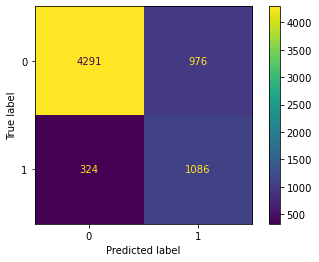

In [113]:
plot_confusion_matrix(best_model_h1n1, X_test, y_test.h1n1_vaccine)
plt.show();

In [71]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

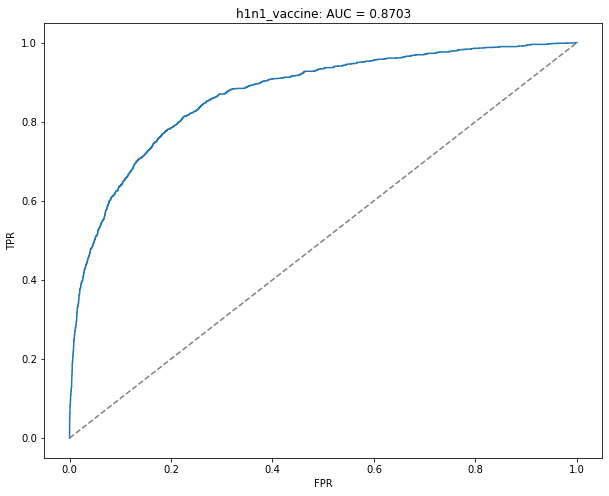

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    best_pred_h1n1, 
    'h1n1_vaccine',
    ax=ax
)

### Seasonal Vaccine

In [74]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [75]:
def objective2(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3),
        'random_strength':trial.suggest_int('random_strength', 1,10),
        'bagging_temperature':trial.suggest_int('bagging_temperature', 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree']),
        'od_type' : "Iter",
        'od_wait' : 100,
        'depth': trial.suggest_int('max_depth', 2,10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        'loss_function': 'Logloss',
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=True, verbose=False)

    return scores['test-AUC-mean'].max()

In [76]:
sampler = optuna.samplers.TPESampler(seed=68)
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

[I 2022-01-26 17:39:25,534] A new study created in memory with name: no-name-0c0a618f-5d43-40f3-87cb-0621ee2900ee


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4624059674
bestIteration = 127

Training on fold [1/5]

bestTest = 0.4775285429
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4668221764
bestIteration = 152

Training on fold [3/5]

bestTest = 0.4690573884
bestIteration = 108

Training on fold [4/5]


[I 2022-01-26 17:40:07,598] Trial 0 finished with value: 0.8612385183893709 and parameters: {'iterations': 1500, 'learning_rate': 0.08961999953042239, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0011812125446097113, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.8612385183893709.



bestTest = 0.4508873272
bestIteration = 167



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.459367151
bestIteration = 78

Training on fold [1/5]

bestTest = 0.4672221176
bestIteration = 85

Training on fold [2/5]

bestTest = 0.4627921364
bestIteration = 72

Training on fold [3/5]

bestTest = 0.4569278772
bestIteration = 117

Training on fold [4/5]


[I 2022-01-26 17:40:10,249] Trial 1 finished with value: 0.8644927244952644 and parameters: {'iterations': 1000, 'learning_rate': 0.2957047309441607, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.001354720669824658, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.8644927244952644.



bestTest = 0.4510511681
bestIteration = 108



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4609578114
bestIteration = 178

Training on fold [1/5]

bestTest = 0.4665927869
bestIteration = 246

Training on fold [2/5]

bestTest = 0.460579581
bestIteration = 205

Training on fold [3/5]

bestTest = 0.455257906
bestIteration = 284

Training on fold [4/5]


[I 2022-01-26 17:40:16,036] Trial 2 finished with value: 0.8653443572136345 and parameters: {'iterations': 1200, 'learning_rate': 0.1371525795360902, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.0048185425547954824, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.449651354
bestIteration = 225



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4939262136
bestIteration = 102

Training on fold [1/5]

bestTest = 0.5020594822
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4873110976
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5016280756
bestIteration = 118

Training on fold [4/5]


[I 2022-01-26 17:41:04,037] Trial 3 finished with value: 0.8479749358772916 and parameters: {'iterations': 300, 'learning_rate': 0.026623822549052163, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 1.9008463722440555e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.4912932762
bestIteration = 129



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4679420296
bestIteration = 869

Training on fold [1/5]

bestTest = 0.4768177701
bestIteration = 999

Training on fold [2/5]

bestTest = 0.471796305
bestIteration = 905

Training on fold [3/5]

bestTest = 0.4690560757
bestIteration = 999

Training on fold [4/5]

bestTest = 0.459017201
bestIteration = 999



[I 2022-01-26 17:41:43,309] Trial 4 finished with value: 0.8615670251294348 and parameters: {'iterations': 1000, 'learning_rate': 0.007101034052723374, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.005827202489296445, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4592573359
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4679461033
bestIteration = 77

Training on fold [2/5]

bestTest = 0.4623240356
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4566058998
bestIteration = 96

Training on fold [4/5]


[I 2022-01-26 17:41:46,038] Trial 5 finished with value: 0.8646097366870045 and parameters: {'iterations': 1500, 'learning_rate': 0.2964430813582234, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 1.7622702261668875e-07, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8653443572136345.



bestTest = 0.4464591106
bestIteration = 137



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560488489
bestIteration = 54

Training on fold [1/5]

bestTest = 0.4651861607
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4527406763
bestIteration = 66

Training on fold [3/5]

bestTest = 0.450974487
bestIteration = 79

Training on fold [4/5]


[I 2022-01-26 17:42:08,051] Trial 6 finished with value: 0.86833548032738 and parameters: {'iterations': 300, 'learning_rate': 0.22423670437233847, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 23.41661191676168, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4430639459
bestIteration = 66



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5222214319
bestIteration = 16

Training on fold [1/5]

bestTest = 0.5450952267
bestIteration = 12

Training on fold [2/5]

bestTest = 0.5172339306
bestIteration = 18

Training on fold [3/5]

bestTest = 0.5255905034
bestIteration = 17

Training on fold [4/5]


[I 2022-01-26 17:42:10,616] Trial 7 finished with value: 0.825964607314283 and parameters: {'iterations': 1500, 'learning_rate': 0.1253699635699981, 'random_strength': 7, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.8307160689696775e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.5122508569
bestIteration = 16



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4904258385
bestIteration = 150

Training on fold [1/5]

bestTest = 0.501588308
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4895621869
bestIteration = 157

Training on fold [3/5]

bestTest = 0.4906704986
bestIteration = 162

Training on fold [4/5]


[I 2022-01-26 17:42:27,182] Trial 8 finished with value: 0.8507894843105575 and parameters: {'iterations': 1000, 'learning_rate': 0.00957473821190967, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0003332900472045444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4749435184
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5248115503
bestIteration = 6

Training on fold [1/5]

bestTest = 0.5268995245
bestIteration = 4

Training on fold [2/5]

bestTest = 0.5169204735
bestIteration = 4

Training on fold [3/5]

bestTest = 0.516185756
bestIteration = 6

Training on fold [4/5]


[I 2022-01-26 17:42:28,909] Trial 9 finished with value: 0.830463934521644 and parameters: {'iterations': 1000, 'learning_rate': 0.2301364835144914, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.0013398579507442577, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.5067246816
bestIteration = 6



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548207501
bestIteration = 95

Training on fold [1/5]

bestTest = 0.460718278
bestIteration = 114

Training on fold [2/5]

bestTest = 0.451866767
bestIteration = 121

Training on fold [3/5]

bestTest = 0.4561457492
bestIteration = 94

Training on fold [4/5]


[I 2022-01-26 17:42:49,260] Trial 10 finished with value: 0.8682748175087112 and parameters: {'iterations': 300, 'learning_rate': 0.21210578031115196, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4459647329
bestIteration = 94



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4547663993
bestIteration = 109

Training on fold [1/5]

bestTest = 0.4627484234
bestIteration = 111

Training on fold [2/5]

bestTest = 0.4518510571
bestIteration = 115

Training on fold [3/5]

bestTest = 0.4543600222
bestIteration = 90

Training on fold [4/5]


[I 2022-01-26 17:43:09,933] Trial 11 finished with value: 0.8682894916311558 and parameters: {'iterations': 300, 'learning_rate': 0.21179272225527906, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 34.56103765349822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4438105499
bestIteration = 126



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4546200472
bestIteration = 73

Training on fold [1/5]

bestTest = 0.4623714815
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4532286823
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4531781703
bestIteration = 102

Training on fold [4/5]


[I 2022-01-26 17:43:29,659] Trial 12 finished with value: 0.8680021596352823 and parameters: {'iterations': 300, 'learning_rate': 0.21371183387618528, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 95.0310408809215, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4462684924
bestIteration = 104



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4633551629
bestIteration = 36

Training on fold [1/5]

bestTest = 0.4738903918
bestIteration = 56

Training on fold [2/5]

bestTest = 0.461675979
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4695266004
bestIteration = 40

Training on fold [4/5]


[I 2022-01-26 17:43:53,059] Trial 13 finished with value: 0.861533275577447 and parameters: {'iterations': 500, 'learning_rate': 0.19045086165750252, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.8236334555490133, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4544806938
bestIteration = 52



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4594321445
bestIteration = 56

Training on fold [1/5]

bestTest = 0.4628819753
bestIteration = 116

Training on fold [2/5]

bestTest = 0.4569692217
bestIteration = 64

Training on fold [3/5]

bestTest = 0.4555857316
bestIteration = 81

Training on fold [4/5]


[I 2022-01-26 17:44:08,406] Trial 14 finished with value: 0.8663457429675621 and parameters: {'iterations': 300, 'learning_rate': 0.24917216994779037, 'random_strength': 4, 'bagging_temperature': 4, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 0.7466656179671237, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4467341806
bestIteration = 70



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4612849473
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4678233458
bestIteration = 72

Training on fold [2/5]

bestTest = 0.4572725541
bestIteration = 81

Training on fold [3/5]

bestTest = 0.4603862167
bestIteration = 61

Training on fold [4/5]


[I 2022-01-26 17:44:36,461] Trial 15 finished with value: 0.865081408654486 and parameters: {'iterations': 300, 'learning_rate': 0.1739341400194549, 'random_strength': 6, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.8549315771643822, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4481103969
bestIteration = 74



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4556062509
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4622056764
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4579888095
bestIteration = 54

Training on fold [3/5]

bestTest = 0.4554969837
bestIteration = 51

Training on fold [4/5]


[I 2022-01-26 17:44:53,416] Trial 16 finished with value: 0.8671270255327341 and parameters: {'iterations': 1200, 'learning_rate': 0.26053855113572677, 'random_strength': 3, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 6.429309779261425, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4462674534
bestIteration = 65



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4750217257
bestIteration = 27

Training on fold [1/5]

bestTest = 0.4833010346
bestIteration = 40

Training on fold [2/5]

bestTest = 0.4722182847
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4773769106
bestIteration = 48

Training on fold [4/5]


[I 2022-01-26 17:45:13,941] Trial 17 finished with value: 0.8542758128566789 and parameters: {'iterations': 500, 'learning_rate': 0.162290906081111, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.06306159710746394, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.468587619
bestIteration = 31



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4596113792
bestIteration = 191

Training on fold [1/5]

bestTest = 0.4642100854
bestIteration = 242

Training on fold [2/5]

bestTest = 0.4570876374
bestIteration = 275

Training on fold [3/5]

bestTest = 0.4574158365
bestIteration = 214

Training on fold [4/5]


[I 2022-01-26 17:45:20,612] Trial 18 finished with value: 0.8659593007553548 and parameters: {'iterations': 300, 'learning_rate': 0.08253977991457023, 'random_strength': 7, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 2.8479737297402608e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4506592319
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.454352057
bestIteration = 59

Training on fold [1/5]

bestTest = 0.4651791855
bestIteration = 50

Training on fold [2/5]

bestTest = 0.4549420499
bestIteration = 72

Training on fold [3/5]

bestTest = 0.4519337441
bestIteration = 73

Training on fold [4/5]


[I 2022-01-26 17:45:39,494] Trial 19 finished with value: 0.8671474793762928 and parameters: {'iterations': 300, 'learning_rate': 0.2621547368672365, 'random_strength': 3, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 10.225320123105696, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4465499557
bestIteration = 81



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4668955947
bestIteration = 47

Training on fold [1/5]

bestTest = 0.4725374891
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4710617396
bestIteration = 60

Training on fold [3/5]

bestTest = 0.466821774
bestIteration = 56

Training on fold [4/5]


[I 2022-01-26 17:46:03,721] Trial 20 finished with value: 0.859570490685557 and parameters: {'iterations': 300, 'learning_rate': 0.19280316585525661, 'random_strength': 7, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.06889212297158703, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4568255715
bestIteration = 63



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560042616
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4615313839
bestIteration = 107

Training on fold [2/5]

bestTest = 0.45191141
bestIteration = 125

Training on fold [3/5]

bestTest = 0.4549006457
bestIteration = 73

Training on fold [4/5]


[I 2022-01-26 17:46:24,414] Trial 21 finished with value: 0.8681165045015546 and parameters: {'iterations': 300, 'learning_rate': 0.21082492056123503, 'random_strength': 4, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 64.54115703707609, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4452026642
bestIteration = 119



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4549004515
bestIteration = 62

Training on fold [1/5]

bestTest = 0.4680499604
bestIteration = 58

Training on fold [2/5]

bestTest = 0.4538510977
bestIteration = 64

Training on fold [3/5]

bestTest = 0.4535899907
bestIteration = 68

Training on fold [4/5]


[I 2022-01-26 17:46:44,043] Trial 22 finished with value: 0.867188633358564 and parameters: {'iterations': 300, 'learning_rate': 0.23551124364277715, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 17.4112617465734, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4429296595
bestIteration = 96



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4537640962
bestIteration = 137

Training on fold [1/5]

bestTest = 0.465720639
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4561693594
bestIteration = 103

Training on fold [3/5]

bestTest = 0.4567465798
bestIteration = 89

Training on fold [4/5]


[I 2022-01-26 17:47:00,573] Trial 23 finished with value: 0.8670654235871327 and parameters: {'iterations': 300, 'learning_rate': 0.20644541534625796, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 3.7174919929890318, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4459062557
bestIteration = 125



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4577440893
bestIteration = 58

Training on fold [1/5]

bestTest = 0.4699738318
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4581649119
bestIteration = 69

Training on fold [3/5]

bestTest = 0.4559630557
bestIteration = 81

Training on fold [4/5]


[I 2022-01-26 17:47:11,899] Trial 24 finished with value: 0.8657928842815806 and parameters: {'iterations': 500, 'learning_rate': 0.2748235218781543, 'random_strength': 6, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.1444419042507601, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4443613163
bestIteration = 133



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548014019
bestIteration = 102

Training on fold [1/5]

bestTest = 0.466194199
bestIteration = 95

Training on fold [2/5]

bestTest = 0.4530714897
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4549644066
bestIteration = 94

Training on fold [4/5]


[I 2022-01-26 17:47:37,135] Trial 25 finished with value: 0.8674981979173493 and parameters: {'iterations': 1200, 'learning_rate': 0.22942372750746504, 'random_strength': 4, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 91.73489550576943, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4442731447
bestIteration = 90



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4607686478
bestIteration = 44

Training on fold [1/5]

bestTest = 0.4735672047
bestIteration = 41

Training on fold [2/5]

bestTest = 0.456813536
bestIteration = 60

Training on fold [3/5]

bestTest = 0.4600268117
bestIteration = 39

Training on fold [4/5]


[I 2022-01-26 17:47:59,440] Trial 26 finished with value: 0.8634044391769322 and parameters: {'iterations': 300, 'learning_rate': 0.17915933563789485, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.9974048457037377, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4532801501
bestIteration = 62



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4564108104
bestIteration = 103

Training on fold [1/5]

bestTest = 0.4611165447
bestIteration = 115

Training on fold [2/5]

bestTest = 0.4532960358
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4534980435
bestIteration = 91

Training on fold [4/5]


[I 2022-01-26 17:48:29,367] Trial 27 finished with value: 0.8682983179173618 and parameters: {'iterations': 300, 'learning_rate': 0.1525974170025792, 'random_strength': 5, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 19.945758595783783, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4441361047
bestIteration = 101



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4856971419
bestIteration = 34

Training on fold [1/5]

bestTest = 0.5009984742
bestIteration = 41

Training on fold [2/5]

bestTest = 0.4884388434
bestIteration = 36

Training on fold [3/5]

bestTest = 0.495553855
bestIteration = 31

Training on fold [4/5]


[I 2022-01-26 17:48:48,140] Trial 28 finished with value: 0.8470682777402434 and parameters: {'iterations': 300, 'learning_rate': 0.10886755228639378, 'random_strength': 5, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 1.0595003544247859e-08, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4864372751
bestIteration = 19



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4586023091
bestIteration = 163

Training on fold [1/5]

bestTest = 0.4681910953
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4554000488
bestIteration = 188

Training on fold [3/5]

bestTest = 0.4621193693
bestIteration = 180

Training on fold [4/5]


[I 2022-01-26 17:49:43,086] Trial 29 finished with value: 0.8654828486539197 and parameters: {'iterations': 1500, 'learning_rate': 0.07630394021032791, 'random_strength': 8, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.11165438757877619, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.4486036027
bestIteration = 213



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4552154764
bestIteration = 72

Training on fold [1/5]

bestTest = 0.466595075
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4534960141
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4566691081
bestIteration = 83

Training on fold [4/5]


[I 2022-01-26 17:50:11,446] Trial 30 finished with value: 0.8670336711075939 and parameters: {'iterations': 300, 'learning_rate': 0.16384258263443902, 'random_strength': 6, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 21.517112181063595, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.86833548032738.



bestTest = 0.445178288
bestIteration = 88



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4527643904
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4654314989
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4519697864
bestIteration = 139

Training on fold [3/5]

bestTest = 0.4533394224
bestIteration = 114

Training on fold [4/5]


[I 2022-01-26 17:50:34,984] Trial 31 finished with value: 0.868623387977953 and parameters: {'iterations': 300, 'learning_rate': 0.15327526907128053, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'l2_leaf_reg': 18.829147866534395, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4430726967
bestIteration = 145



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4577466849
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4615679804
bestIteration = 93

Training on fold [2/5]

bestTest = 0.4536579219
bestIteration = 117

Training on fold [3/5]

bestTest = 0.4557918218
bestIteration = 99

Training on fold [4/5]


[I 2022-01-26 17:50:39,686] Trial 32 finished with value: 0.8678891954762836 and parameters: {'iterations': 300, 'learning_rate': 0.15047499795280334, 'random_strength': 5, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 17.237859843399594, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4429327391
bestIteration = 146



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4624645836
bestIteration = 77

Training on fold [1/5]

bestTest = 0.4724219904
bestIteration = 69

Training on fold [2/5]

bestTest = 0.4626517037
bestIteration = 80

Training on fold [3/5]

bestTest = 0.4631117118
bestIteration = 99

Training on fold [4/5]


[I 2022-01-26 17:51:14,975] Trial 33 finished with value: 0.862549984085285 and parameters: {'iterations': 300, 'learning_rate': 0.11851248520978816, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.3545828548311504, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4564283853
bestIteration = 82



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4544873734
bestIteration = 159

Training on fold [1/5]

bestTest = 0.4647863089
bestIteration = 148

Training on fold [2/5]

bestTest = 0.4574013088
bestIteration = 137

Training on fold [3/5]

bestTest = 0.4582451989
bestIteration = 141

Training on fold [4/5]


[I 2022-01-26 17:51:22,019] Trial 34 finished with value: 0.8668699208349899 and parameters: {'iterations': 1200, 'learning_rate': 0.10279586303682202, 'random_strength': 7, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 3.149837766613654, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4462076871
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4588609533
bestIteration = 119

Training on fold [1/5]

bestTest = 0.4650155187
bestIteration = 147

Training on fold [2/5]

bestTest = 0.4604974702
bestIteration = 127

Training on fold [3/5]

bestTest = 0.4563509413
bestIteration = 138

Training on fold [4/5]


[I 2022-01-26 17:51:26,524] Trial 35 finished with value: 0.8658023675547728 and parameters: {'iterations': 300, 'learning_rate': 0.1491570806594793, 'random_strength': 9, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'l2_leaf_reg': 0.01471940580521533, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.868623387977953.



bestTest = 0.4485632728
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.45576501
bestIteration = 241

Training on fold [1/5]

bestTest = 0.4652309276
bestIteration = 222

Training on fold [2/5]

bestTest = 0.4523320283
bestIteration = 234

Training on fold [3/5]

bestTest = 0.4514290013
bestIteration = 240

Training on fold [4/5]


[I 2022-01-26 17:53:17,666] Trial 36 finished with value: 0.8691179999511197 and parameters: {'iterations': 1500, 'learning_rate': 0.05782509318844685, 'random_strength': 6, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 19.59519475239158, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4432348434
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.456756076
bestIteration = 219

Training on fold [1/5]

bestTest = 0.4691437706
bestIteration = 201

Training on fold [2/5]

bestTest = 0.4531525201
bestIteration = 228

Training on fold [3/5]

bestTest = 0.4599414115
bestIteration = 158

Training on fold [4/5]


[I 2022-01-26 17:55:02,727] Trial 37 finished with value: 0.8664077366278718 and parameters: {'iterations': 1500, 'learning_rate': 0.049381272672382556, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 4.949898948021792, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4520018394
bestIteration = 174



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4754187609
bestIteration = 109

Training on fold [1/5]

bestTest = 0.4927614569
bestIteration = 79

Training on fold [2/5]

bestTest = 0.4857874896
bestIteration = 72

Training on fold [3/5]

bestTest = 0.489158783
bestIteration = 58

Training on fold [4/5]


[I 2022-01-26 17:55:46,788] Trial 38 finished with value: 0.8509611808821095 and parameters: {'iterations': 1500, 'learning_rate': 0.058746124286410926, 'random_strength': 8, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0.00020837494437933067, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4816807591
bestIteration = 97



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4799728533
bestIteration = 27

Training on fold [1/5]

bestTest = 0.5021150283
bestIteration = 28

Training on fold [2/5]

bestTest = 0.4886581964
bestIteration = 35

Training on fold [3/5]

bestTest = 0.4915700797
bestIteration = 36

Training on fold [4/5]


[I 2022-01-26 17:55:49,704] Trial 39 finished with value: 0.8465715359891129 and parameters: {'iterations': 1500, 'learning_rate': 0.13681596355727818, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0.01681741846683415, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4794646898
bestIteration = 42



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4602236612
bestIteration = 944

Training on fold [1/5]

bestTest = 0.467833909
bestIteration = 998

Training on fold [2/5]

bestTest = 0.4619646081
bestIteration = 904

Training on fold [3/5]

bestTest = 0.4601061347
bestIteration = 996

Training on fold [4/5]

bestTest = 0.4519712318
bestIteration = 998



[I 2022-01-26 17:56:14,301] Trial 40 finished with value: 0.8649900842939479 and parameters: {'iterations': 1000, 'learning_rate': 0.025508535042355132, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 2, 'l2_leaf_reg': 0.329955338437481, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539199127
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4642611313
bestIteration = 105

Training on fold [2/5]

bestTest = 0.451271339
bestIteration = 114

Training on fold [3/5]

bestTest = 0.4517245683
bestIteration = 123

Training on fold [4/5]


[I 2022-01-26 17:56:55,386] Trial 41 finished with value: 0.8689625262349423 and parameters: {'iterations': 1500, 'learning_rate': 0.13124379928420676, 'random_strength': 5, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 21.460778100104363, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4413975975
bestIteration = 166



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4550147302
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4632797129
bestIteration = 152

Training on fold [2/5]

bestTest = 0.4529987218
bestIteration = 189

Training on fold [3/5]

bestTest = 0.4533216015
bestIteration = 159

Training on fold [4/5]


[I 2022-01-26 17:57:42,112] Trial 42 finished with value: 0.8685208738740027 and parameters: {'iterations': 1500, 'learning_rate': 0.09369107780601738, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 1.6899148706207925, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.44336942
bestIteration = 150



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4560444914
bestIteration = 197

Training on fold [1/5]

bestTest = 0.468288747
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4539409115
bestIteration = 220

Training on fold [3/5]

bestTest = 0.4587027564
bestIteration = 189

Training on fold [4/5]

bestTest = 0.4455519214
bestIteration = 210



[I 2022-01-26 17:58:56,466] Trial 43 finished with value: 0.8668700030967557 and parameters: {'iterations': 1500, 'learning_rate': 0.06331053727900046, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.900786593243464, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4561156642
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4627068958
bestIteration = 142

Training on fold [2/5]

bestTest = 0.4544523417
bestIteration = 154

Training on fold [3/5]

bestTest = 0.4529164051
bestIteration = 169

Training on fold [4/5]


[I 2022-01-26 17:59:42,557] Trial 44 finished with value: 0.8682950536828071 and parameters: {'iterations': 1500, 'learning_rate': 0.09636096888970697, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 8.679226567154252, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4437425227
bestIteration = 174



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4516850731
bestIteration = 354

Training on fold [1/5]

bestTest = 0.4677607241
bestIteration = 321

Training on fold [2/5]

bestTest = 0.4522586981
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4534826906
bestIteration = 364

Training on fold [4/5]


[I 2022-01-26 18:02:04,008] Trial 45 finished with value: 0.8690915529098812 and parameters: {'iterations': 1500, 'learning_rate': 0.040137316359271646, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 31.863165241478427, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4413194696
bestIteration = 402



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4524000625
bestIteration = 368

Training on fold [1/5]

bestTest = 0.4665751252
bestIteration = 363

Training on fold [2/5]

bestTest = 0.4511078695
bestIteration = 442

Training on fold [3/5]

bestTest = 0.4535432973
bestIteration = 426

Training on fold [4/5]


[I 2022-01-26 18:05:05,347] Trial 46 finished with value: 0.8688896879260024 and parameters: {'iterations': 1500, 'learning_rate': 0.03695669381593769, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 47.39666877667559, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 36 with value: 0.8691179999511197.



bestTest = 0.4439874736
bestIteration = 395



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4513168211
bestIteration = 530

Training on fold [1/5]

bestTest = 0.466604386
bestIteration = 548

Training on fold [2/5]

bestTest = 0.4506277001
bestIteration = 606

Training on fold [3/5]

bestTest = 0.4540052039
bestIteration = 561

Training on fold [4/5]


[I 2022-01-26 18:09:21,837] Trial 47 finished with value: 0.8694777014973075 and parameters: {'iterations': 1500, 'learning_rate': 0.02607672451652509, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 40.166476760488095, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.



bestTest = 0.4424055802
bestIteration = 570



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4530316565
bestIteration = 502

Training on fold [1/5]

bestTest = 0.4665514104
bestIteration = 465

Training on fold [2/5]

bestTest = 0.4500867164
bestIteration = 575

Training on fold [3/5]

bestTest = 0.4538169794
bestIteration = 508

Training on fold [4/5]


[I 2022-01-26 18:13:26,132] Trial 48 finished with value: 0.8692699670704706 and parameters: {'iterations': 1500, 'learning_rate': 0.02903957348747238, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 48.63222906871405, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.



bestTest = 0.4415887703
bestIteration = 629



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4916215304
bestIteration = 287

Training on fold [1/5]

bestTest = 0.5062865141
bestIteration = 268

Training on fold [2/5]

bestTest = 0.4991387999
bestIteration = 260

Training on fold [3/5]

bestTest = 0.4978463669
bestIteration = 258

Training on fold [4/5]


[I 2022-01-26 18:13:49,803] Trial 49 finished with value: 0.8471002556186364 and parameters: {'iterations': 1500, 'learning_rate': 0.009857061869506634, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 2.036223340140397e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 47 with value: 0.8694777014973075.



bestTest = 0.489511822
bestIteration = 292



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.451609167
bestIteration = 634

Training on fold [1/5]

bestTest = 0.4628415484
bestIteration = 661

Training on fold [2/5]

bestTest = 0.4507780048
bestIteration = 652

Training on fold [3/5]

bestTest = 0.4556166878
bestIteration = 600

Training on fold [4/5]

bestTest = 0.4424841344
bestIteration = 663



[I 2022-01-26 18:18:15,892] Trial 50 finished with value: 0.8696074773891876 and parameters: {'iterations': 1500, 'learning_rate': 0.022390550678127702, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 35.68473917744485, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4517706879
bestIteration = 601

Training on fold [1/5]

bestTest = 0.4644822777
bestIteration = 602

Training on fold [2/5]

bestTest = 0.4520425126
bestIteration = 584

Training on fold [3/5]

bestTest = 0.452608932
bestIteration = 636

Training on fold [4/5]


[I 2022-01-26 18:22:28,771] Trial 51 finished with value: 0.8692368208807949 and parameters: {'iterations': 1500, 'learning_rate': 0.02437227321885385, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 39.571542648455164, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4441296772
bestIteration = 621



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4517564692
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4649992874
bestIteration = 551

Training on fold [2/5]

bestTest = 0.4518733411
bestIteration = 701

Training on fold [3/5]

bestTest = 0.4532398826
bestIteration = 602

Training on fold [4/5]


[I 2022-01-26 18:26:35,871] Trial 52 finished with value: 0.8695940341518043 and parameters: {'iterations': 1500, 'learning_rate': 0.027169499177914887, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 90.71192378745138, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4404675528
bestIteration = 645



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4512486053
bestIteration = 826

Training on fold [1/5]

bestTest = 0.4673026031
bestIteration = 752

Training on fold [2/5]

bestTest = 0.4501290575
bestIteration = 943

Training on fold [3/5]

bestTest = 0.4548917244
bestIteration = 777

Training on fold [4/5]

bestTest = 0.4421721144
bestIteration = 892



[I 2022-01-26 18:32:59,776] Trial 53 finished with value: 0.8692265086097217 and parameters: {'iterations': 1500, 'learning_rate': 0.018118184940708278, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 93.85459899821991, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4520772497
bestIteration = 730

Training on fold [1/5]

bestTest = 0.4653221417
bestIteration = 681

Training on fold [2/5]

bestTest = 0.4518740443
bestIteration = 797

Training on fold [3/5]

bestTest = 0.4536606445
bestIteration = 818

Training on fold [4/5]

bestTest = 0.4418987169
bestIteration = 805



[I 2022-01-26 18:38:17,818] Trial 54 finished with value: 0.8693196951695985 and parameters: {'iterations': 1500, 'learning_rate': 0.02070592720800253, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 96.04979149895247, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529124947
bestIteration = 404

Training on fold [1/5]

bestTest = 0.4654618463
bestIteration = 419

Training on fold [2/5]

bestTest = 0.4536441105
bestIteration = 419

Training on fold [3/5]

bestTest = 0.4549922019
bestIteration = 405

Training on fold [4/5]


[I 2022-01-26 18:41:03,346] Trial 55 finished with value: 0.8686962074598675 and parameters: {'iterations': 1500, 'learning_rate': 0.034281535343183345, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 7.861751896874512, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4444776831
bestIteration = 427



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4820977376
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4944320586
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4865144121
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4874961786
bestIteration = 1499

Training on fold [4/5]

bestTest = 0.4817637195
bestIteration = 1499



[I 2022-01-26 18:51:21,312] Trial 56 finished with value: 0.8596820149749707 and parameters: {'iterations': 1500, 'learning_rate': 0.0024457771239027246, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 46.548044093728834, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4537205661
bestIteration = 639

Training on fold [1/5]

bestTest = 0.4627896155
bestIteration = 689

Training on fold [2/5]

bestTest = 0.454231622
bestIteration = 706

Training on fold [3/5]

bestTest = 0.4579421715
bestIteration = 606

Training on fold [4/5]

bestTest = 0.4453428638
bestIteration = 649



[I 2022-01-26 18:51:55,679] Trial 57 finished with value: 0.8686434423522297 and parameters: {'iterations': 1500, 'learning_rate': 0.02033323814211424, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 7.360970579561716, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4525365255
bestIteration = 288

Training on fold [1/5]

bestTest = 0.4670586794
bestIteration = 281

Training on fold [2/5]

bestTest = 0.4516229128
bestIteration = 304

Training on fold [3/5]

bestTest = 0.453090184
bestIteration = 302

Training on fold [4/5]


[I 2022-01-26 18:53:58,357] Trial 58 finished with value: 0.8692945612233277 and parameters: {'iterations': 1000, 'learning_rate': 0.04831844243705542, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 56.412594382766954, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4422749368
bestIteration = 336



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4718592219
bestIteration = 140

Training on fold [1/5]

bestTest = 0.4823025006
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4706182111
bestIteration = 152

Training on fold [3/5]

bestTest = 0.4771785479
bestIteration = 142

Training on fold [4/5]


[I 2022-01-26 18:54:11,861] Trial 59 finished with value: 0.8582774008815282 and parameters: {'iterations': 1000, 'learning_rate': 0.04285057459168701, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 0.7502198649369821, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4622810719
bestIteration = 173



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.45452513
bestIteration = 200

Training on fold [1/5]

bestTest = 0.4663567926
bestIteration = 185

Training on fold [2/5]

bestTest = 0.455391026
bestIteration = 204

Training on fold [3/5]

bestTest = 0.4537771418
bestIteration = 210

Training on fold [4/5]


[I 2022-01-26 18:55:41,489] Trial 60 finished with value: 0.8682452715412546 and parameters: {'iterations': 1000, 'learning_rate': 0.0707684633019203, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 81.71227354286059, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4413340608
bestIteration = 242



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4535102248
bestIteration = 997

Training on fold [1/5]

bestTest = 0.4670148256
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4551340511
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4568129845
bestIteration = 999

Training on fold [4/5]

bestTest = 0.4480992203
bestIteration = 999



[I 2022-01-26 19:03:12,071] Trial 61 finished with value: 0.8678612787295199 and parameters: {'iterations': 1000, 'learning_rate': 0.012258709799064875, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 37.737183713376254, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4527445718
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4669377052
bestIteration = 496

Training on fold [2/5]

bestTest = 0.4545144984
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4564086372
bestIteration = 498

Training on fold [4/5]


[I 2022-01-26 19:06:48,915] Trial 62 finished with value: 0.8682833137154313 and parameters: {'iterations': 500, 'learning_rate': 0.026842122656220057, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 93.59717508228827, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4455137422
bestIteration = 499



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.462399521
bestIteration = 175

Training on fold [1/5]

bestTest = 0.47010587
bestIteration = 230

Training on fold [2/5]

bestTest = 0.4623404158
bestIteration = 196

Training on fold [3/5]

bestTest = 0.4589608151
bestIteration = 286

Training on fold [4/5]


[I 2022-01-26 19:08:22,877] Trial 63 finished with value: 0.8658304450946416 and parameters: {'iterations': 1500, 'learning_rate': 0.048630044425395876, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 10.220437656909871, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4444824412
bestIteration = 275



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.455800987
bestIteration = 442

Training on fold [1/5]

bestTest = 0.4687804855
bestIteration = 427

Training on fold [2/5]

bestTest = 0.4524089767
bestIteration = 546

Training on fold [3/5]

bestTest = 0.4586884361
bestIteration = 425

Training on fold [4/5]


[I 2022-01-26 19:11:39,652] Trial 64 finished with value: 0.867932840307762 and parameters: {'iterations': 1500, 'learning_rate': 0.02735256426542132, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.9149112161454482, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4439509891
bestIteration = 542



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.475861151
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4886341539
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4792025377
bestIteration = 999

Training on fold [3/5]

bestTest = 0.479301429
bestIteration = 999

Training on fold [4/5]

bestTest = 0.4743468285
bestIteration = 999



[I 2022-01-26 19:17:35,073] Trial 65 finished with value: 0.8607406870385865 and parameters: {'iterations': 1000, 'learning_rate': 0.005316637645229853, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 38.90600218477495, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4541801087
bestIteration = 722

Training on fold [1/5]

bestTest = 0.4681479096
bestIteration = 678

Training on fold [2/5]

bestTest = 0.4515597406
bestIteration = 884

Training on fold [3/5]

bestTest = 0.4575415499
bestIteration = 757

Training on fold [4/5]

bestTest = 0.4452557056
bestIteration = 857



[I 2022-01-26 19:23:20,440] Trial 66 finished with value: 0.8679689987962579 and parameters: {'iterations': 1500, 'learning_rate': 0.01689671201634786, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 10.99927339643926, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4575772919
bestIteration = 250

Training on fold [1/5]

bestTest = 0.4640143234
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4541584584
bestIteration = 291

Training on fold [3/5]

bestTest = 0.4559088714
bestIteration = 254

Training on fold [4/5]


[I 2022-01-26 19:23:34,481] Trial 67 finished with value: 0.8678932118576276 and parameters: {'iterations': 1200, 'learning_rate': 0.05239079510413963, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 4.565894129561205, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4474323601
bestIteration = 260



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4531028806
bestIteration = 409

Training on fold [1/5]

bestTest = 0.467084805
bestIteration = 424

Training on fold [2/5]

bestTest = 0.4536708879
bestIteration = 441

Training on fold [3/5]

bestTest = 0.4536403851
bestIteration = 415

Training on fold [4/5]


[I 2022-01-26 19:26:26,058] Trial 68 finished with value: 0.8690227076587345 and parameters: {'iterations': 1500, 'learning_rate': 0.03244704166745377, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 34.58742148212441, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4420079142
bestIteration = 459



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5840655361
bestIteration = 499

Training on fold [1/5]

bestTest = 0.5880710152
bestIteration = 499

Training on fold [2/5]

bestTest = 0.5860599383
bestIteration = 499

Training on fold [3/5]

bestTest = 0.5889430805
bestIteration = 499

Training on fold [4/5]


[I 2022-01-26 19:29:36,667] Trial 69 finished with value: 0.8479012720354577 and parameters: {'iterations': 500, 'learning_rate': 0.0011781072451653163, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 0.00041468289958679794, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.5831734922
bestIteration = 499



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.455692689
bestIteration = 190

Training on fold [1/5]

bestTest = 0.466477355
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4553438386
bestIteration = 207

Training on fold [3/5]

bestTest = 0.4563609641
bestIteration = 192

Training on fold [4/5]


[I 2022-01-26 19:30:50,976] Trial 70 finished with value: 0.8668786386977958 and parameters: {'iterations': 1500, 'learning_rate': 0.06900716008190771, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1.5110344388769843, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4476676928
bestIteration = 221



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4512521661
bestIteration = 745

Training on fold [1/5]

bestTest = 0.4667512679
bestIteration = 745

Training on fold [2/5]

bestTest = 0.4520758061
bestIteration = 821

Training on fold [3/5]

bestTest = 0.4530359554
bestIteration = 841

Training on fold [4/5]

bestTest = 0.4427440972
bestIteration = 887



[I 2022-01-26 19:36:58,512] Trial 71 finished with value: 0.8691966023598401 and parameters: {'iterations': 1500, 'learning_rate': 0.01901512466773215, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 89.95829694979462, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4508833084
bestIteration = 315

Training on fold [1/5]

bestTest = 0.4666367874
bestIteration = 327

Training on fold [2/5]

bestTest = 0.450918289
bestIteration = 356

Training on fold [3/5]

bestTest = 0.4521623077
bestIteration = 379

Training on fold [4/5]


[I 2022-01-26 19:39:31,670] Trial 72 finished with value: 0.869563535027941 and parameters: {'iterations': 1500, 'learning_rate': 0.043985330597282345, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 56.395540142485245, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4427028571
bestIteration = 326



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4516941286
bestIteration = 180

Training on fold [1/5]

bestTest = 0.4651113535
bestIteration = 168

Training on fold [2/5]

bestTest = 0.4503806007
bestIteration = 216

Training on fold [3/5]

bestTest = 0.4559996473
bestIteration = 178

Training on fold [4/5]


[I 2022-01-26 19:40:44,113] Trial 73 finished with value: 0.8686268646860945 and parameters: {'iterations': 1500, 'learning_rate': 0.08095927233896498, 'random_strength': 10, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 14.48278698934299, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4456830333
bestIteration = 175



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4521848305
bestIteration = 308

Training on fold [1/5]

bestTest = 0.4653788424
bestIteration = 280

Training on fold [2/5]

bestTest = 0.452222022
bestIteration = 319

Training on fold [3/5]

bestTest = 0.4545512069
bestIteration = 290

Training on fold [4/5]


[I 2022-01-26 19:42:46,876] Trial 74 finished with value: 0.8689277753399441 and parameters: {'iterations': 1500, 'learning_rate': 0.047439968026008306, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 10, 'l2_leaf_reg': 47.504364584804534, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4445431497
bestIteration = 326



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4548923137
bestIteration = 402

Training on fold [1/5]

bestTest = 0.4655870936
bestIteration = 431

Training on fold [2/5]

bestTest = 0.451188983
bestIteration = 450

Training on fold [3/5]

bestTest = 0.455287204
bestIteration = 445

Training on fold [4/5]

bestTest = 0.4429294754
bestIteration = 484



[I 2022-01-26 19:46:02,052] Trial 75 finished with value: 0.8687532182388544 and parameters: {'iterations': 1000, 'learning_rate': 0.031032754104378592, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 27.677695140599454, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.454239187
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4706281585
bestIteration = 267

Training on fold [2/5]

bestTest = 0.4546860119
bestIteration = 290

Training on fold [3/5]

bestTest = 0.4604775504
bestIteration = 265

Training on fold [4/5]


[I 2022-01-26 19:48:07,810] Trial 76 finished with value: 0.8666180324744068 and parameters: {'iterations': 1500, 'learning_rate': 0.04300575866839145, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 4.943250301487569, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4473765259
bestIteration = 328



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529918682
bestIteration = 225

Training on fold [1/5]

bestTest = 0.4658784752
bestIteration = 240

Training on fold [2/5]

bestTest = 0.4508361249
bestIteration = 246

Training on fold [3/5]

bestTest = 0.4547432501
bestIteration = 234

Training on fold [4/5]


[I 2022-01-26 19:49:51,540] Trial 77 finished with value: 0.8686921370439581 and parameters: {'iterations': 1500, 'learning_rate': 0.057200895556883645, 'random_strength': 9, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 12.39352517250405, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4456645559
bestIteration = 252



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4533858541
bestIteration = 1102

Training on fold [1/5]

bestTest = 0.4604176137
bestIteration = 1198

Training on fold [2/5]

bestTest = 0.4529551169
bestIteration = 1119

Training on fold [3/5]

bestTest = 0.4539551489
bestIteration = 1144

Training on fold [4/5]

bestTest = 0.4434601827
bestIteration = 1199



[I 2022-01-26 19:50:46,155] Trial 78 finished with value: 0.8693917698005904 and parameters: {'iterations': 1200, 'learning_rate': 0.0129951773537475, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 49.41548581369964, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4712587663
bestIteration = 419

Training on fold [1/5]

bestTest = 0.485764505
bestIteration = 389

Training on fold [2/5]

bestTest = 0.4809165707
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4790506116
bestIteration = 424

Training on fold [4/5]


[I 2022-01-26 19:51:04,383] Trial 79 finished with value: 0.8563951559611456 and parameters: {'iterations': 1200, 'learning_rate': 0.014097888173987223, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 6.420693446980915e-05, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4671397427
bestIteration = 450



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4551056304
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.465146177
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4563498879
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4570094206
bestIteration = 1199

Training on fold [4/5]

bestTest = 0.4479565914
bestIteration = 1199



[I 2022-01-26 19:52:00,819] Trial 80 finished with value: 0.8678407110192883 and parameters: {'iterations': 1200, 'learning_rate': 0.010664733844041693, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 62.65458264363936, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539737734
bestIteration = 559

Training on fold [1/5]

bestTest = 0.4639945651
bestIteration = 585

Training on fold [2/5]

bestTest = 0.4515210549
bestIteration = 667

Training on fold [3/5]

bestTest = 0.4545080404
bestIteration = 605

Training on fold [4/5]


[I 2022-01-26 19:52:32,782] Trial 81 finished with value: 0.8689951955682738 and parameters: {'iterations': 1200, 'learning_rate': 0.023425430955652613, 'random_strength': 9, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 31.52425758832173, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 50 with value: 0.8696074773891876.



bestTest = 0.4440259728
bestIteration = 586



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4523073267
bestIteration = 387

Training on fold [1/5]

bestTest = 0.4600845135
bestIteration = 435

Training on fold [2/5]

bestTest = 0.4511793459
bestIteration = 455

Training on fold [3/5]

bestTest = 0.4534709068
bestIteration = 397

Training on fold [4/5]


[I 2022-01-26 19:52:55,330] Trial 82 finished with value: 0.8700183743522392 and parameters: {'iterations': 1200, 'learning_rate': 0.037220657529181016, 'random_strength': 8, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 62.754825532816156, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4425506717
bestIteration = 437



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4578483876
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4627278099
bestIteration = 334

Training on fold [2/5]

bestTest = 0.4547685435
bestIteration = 345

Training on fold [3/5]

bestTest = 0.4547951634
bestIteration = 343

Training on fold [4/5]


[I 2022-01-26 19:53:15,148] Trial 83 finished with value: 0.8684303690085041 and parameters: {'iterations': 1200, 'learning_rate': 0.03902713688836003, 'random_strength': 8, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 16.46310070649067, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4458011995
bestIteration = 306



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4532971314
bestIteration = 466

Training on fold [1/5]

bestTest = 0.4585768348
bestIteration = 573

Training on fold [2/5]

bestTest = 0.45214446
bestIteration = 519

Training on fold [3/5]

bestTest = 0.4536360058
bestIteration = 518

Training on fold [4/5]


[I 2022-01-26 19:53:38,909] Trial 84 finished with value: 0.8698256501392292 and parameters: {'iterations': 1200, 'learning_rate': 0.03123781068509615, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 55.438976753390506, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4428740915
bestIteration = 484



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4518583422
bestIteration = 184

Training on fold [1/5]

bestTest = 0.4624357598
bestIteration = 177

Training on fold [2/5]

bestTest = 0.4517749535
bestIteration = 210

Training on fold [3/5]

bestTest = 0.4529999567
bestIteration = 213

Training on fold [4/5]


[I 2022-01-26 19:53:48,380] Trial 85 finished with value: 0.8697012195934425 and parameters: {'iterations': 1200, 'learning_rate': 0.0638116167665751, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 61.36033583609983, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4412589404
bestIteration = 203



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4528660447
bestIteration = 424

Training on fold [1/5]

bestTest = 0.4599551254
bestIteration = 507

Training on fold [2/5]

bestTest = 0.4523354422
bestIteration = 503

Training on fold [3/5]

bestTest = 0.454164043
bestIteration = 443

Training on fold [4/5]


[I 2022-01-26 19:54:10,688] Trial 86 finished with value: 0.8698150864852721 and parameters: {'iterations': 1200, 'learning_rate': 0.03416140490492777, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 94.8641858031453, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4413765138
bestIteration = 546



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4541712709
bestIteration = 149

Training on fold [1/5]

bestTest = 0.4611896276
bestIteration = 162

Training on fold [2/5]

bestTest = 0.4536360189
bestIteration = 146

Training on fold [3/5]

bestTest = 0.4543116553
bestIteration = 155

Training on fold [4/5]


[I 2022-01-26 19:54:18,193] Trial 87 finished with value: 0.8690843718204138 and parameters: {'iterations': 1200, 'learning_rate': 0.06817850103106474, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 21.978158419875523, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.443255763
bestIteration = 149



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4554757633
bestIteration = 364

Training on fold [1/5]

bestTest = 0.4607283275
bestIteration = 385

Training on fold [2/5]

bestTest = 0.4545213821
bestIteration = 394

Training on fold [3/5]

bestTest = 0.4566497599
bestIteration = 352

Training on fold [4/5]


[I 2022-01-26 19:54:35,351] Trial 88 finished with value: 0.8680935849634597 and parameters: {'iterations': 1200, 'learning_rate': 0.0375445861828973, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 5.870751798140565, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4468335615
bestIteration = 386



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4568662413
bestIteration = 118

Training on fold [1/5]

bestTest = 0.4641642443
bestIteration = 125

Training on fold [2/5]

bestTest = 0.4559278929
bestIteration = 140

Training on fold [3/5]

bestTest = 0.4548710712
bestIteration = 196

Training on fold [4/5]


[I 2022-01-26 19:54:42,662] Trial 89 finished with value: 0.8680955085529487 and parameters: {'iterations': 1200, 'learning_rate': 0.05595914108498808, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 3.0668509603768164, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.



bestTest = 0.4437698422
bestIteration = 146



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4700941214
bestIteration = 700

Training on fold [1/5]

bestTest = 0.4816423197
bestIteration = 684

Training on fold [2/5]

bestTest = 0.4755316936
bestIteration = 653

Training on fold [3/5]

bestTest = 0.4714789972
bestIteration = 852

Training on fold [4/5]

bestTest = 0.4641840559
bestIteration = 824



[I 2022-01-26 19:55:16,353] Trial 90 finished with value: 0.8586783109763715 and parameters: {'iterations': 1200, 'learning_rate': 0.008215387769493428, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0.005494109707906634, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 82 with value: 0.8700183743522392.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4515637594
bestIteration = 500

Training on fold [1/5]

bestTest = 0.4586056352
bestIteration = 570

Training on fold [2/5]

bestTest = 0.4523628431
bestIteration = 518

Training on fold [3/5]

bestTest = 0.4523220163
bestIteration = 518

Training on fold [4/5]


[I 2022-01-26 19:55:40,812] Trial 91 finished with value: 0.8704345800352724 and parameters: {'iterations': 1200, 'learning_rate': 0.032532364424905896, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 90.47412147528497, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.440423152
bestIteration = 546



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4539178336
bestIteration = 408

Training on fold [1/5]

bestTest = 0.4625582057
bestIteration = 452

Training on fold [2/5]

bestTest = 0.4507877124
bestIteration = 500

Training on fold [3/5]

bestTest = 0.4531769368
bestIteration = 413

Training on fold [4/5]


[I 2022-01-26 19:56:00,997] Trial 92 finished with value: 0.8694847679540038 and parameters: {'iterations': 1200, 'learning_rate': 0.03308001665223882, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 25.554579585479043, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4425631308
bestIteration = 448



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4524922132
bestIteration = 343

Training on fold [1/5]

bestTest = 0.4605181132
bestIteration = 380

Training on fold [2/5]

bestTest = 0.452861299
bestIteration = 369

Training on fold [3/5]

bestTest = 0.4543793214
bestIteration = 364

Training on fold [4/5]


[I 2022-01-26 19:56:16,485] Trial 93 finished with value: 0.8692459537463831 and parameters: {'iterations': 1200, 'learning_rate': 0.044029906668511, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 26.36604478577444, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4436266493
bestIteration = 378



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4545168027
bestIteration = 216

Training on fold [1/5]

bestTest = 0.4641127077
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4505176263
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4545978738
bestIteration = 217

Training on fold [4/5]


[I 2022-01-26 19:56:27,841] Trial 94 finished with value: 0.8688980900241601 and parameters: {'iterations': 1200, 'learning_rate': 0.06209374759860688, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 13.07652550962233, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4432205927
bestIteration = 243



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4529492334
bestIteration = 431

Training on fold [1/5]

bestTest = 0.460699934
bestIteration = 494

Training on fold [2/5]

bestTest = 0.4521861916
bestIteration = 459

Training on fold [3/5]

bestTest = 0.4526599286
bestIteration = 449

Training on fold [4/5]


[I 2022-01-26 19:56:48,551] Trial 95 finished with value: 0.8695053708893198 and parameters: {'iterations': 1200, 'learning_rate': 0.034848494426571064, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 8, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 68.40985294285782, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4437345431
bestIteration = 424



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4525681629
bestIteration = 412

Training on fold [1/5]

bestTest = 0.4598514397
bestIteration = 464

Training on fold [2/5]

bestTest = 0.4516444439
bestIteration = 473

Training on fold [3/5]

bestTest = 0.4534785901
bestIteration = 421

Training on fold [4/5]


[I 2022-01-26 19:57:09,040] Trial 96 finished with value: 0.8697541691229131 and parameters: {'iterations': 1200, 'learning_rate': 0.03793066324235663, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 66.01742667719492, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4422524076
bestIteration = 457



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4618162728
bestIteration = 222

Training on fold [1/5]

bestTest = 0.4776775902
bestIteration = 233

Training on fold [2/5]

bestTest = 0.4754296362
bestIteration = 125

Training on fold [3/5]

bestTest = 0.472270464
bestIteration = 171

Training on fold [4/5]


[I 2022-01-26 19:57:17,647] Trial 97 finished with value: 0.8598880635801031 and parameters: {'iterations': 1200, 'learning_rate': 0.052956482898884924, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'l2_leaf_reg': 0.0020752124699714787, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4558339824
bestIteration = 257



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4532451321
bestIteration = 367

Training on fold [1/5]

bestTest = 0.4612227489
bestIteration = 470

Training on fold [2/5]

bestTest = 0.4512155755
bestIteration = 421

Training on fold [3/5]

bestTest = 0.4542924679
bestIteration = 394

Training on fold [4/5]


[I 2022-01-26 19:57:37,075] Trial 98 finished with value: 0.8696888605330567 and parameters: {'iterations': 1200, 'learning_rate': 0.03710013044921778, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 65.73743262580484, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4414140681
bestIteration = 490



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4984909105
bestIteration = 54

Training on fold [1/5]

bestTest = 0.5041752766
bestIteration = 43

Training on fold [2/5]

bestTest = 0.4985493437
bestIteration = 43

Training on fold [3/5]

bestTest = 0.5047506632
bestIteration = 31

Training on fold [4/5]


[I 2022-01-26 19:57:40,017] Trial 99 finished with value: 0.8401642240822543 and parameters: {'iterations': 1200, 'learning_rate': 0.08562847835370065, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'max_depth': 8, 'l2_leaf_reg': 2.2732577795359755e-08, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 91 with value: 0.8704345800352724.



bestTest = 0.4976027044
bestIteration = 46



In [77]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))


Number of finished trials: 100
Best trial:
  Value: 0.8704345800352724
  Params: 
    iterations=1200,
    learning_rate=0.032532364424905896,
    random_strength=7,
    bagging_temperature=10,
    max_bin=8,
    grow_policy=SymmetricTree,
    max_depth=7,
    l2_leaf_reg=90.47412147528497,
    one_hot_max_size=500,
    auto_class_weights=Balanced,


In [120]:
params2 = {'iterations':1200,
         'learning_rate':0.032532364424905896,
         'cat_features': categorical_features_indices,
         'random_strength':7,
         'depth':7,
         'max_bin':8,
         'grow_policy':'SymmetricTree',
         'l2_leaf_reg':90.47412147528497,
         'bagging_temperature':10,
         'one_hot_max_size':500,
         'eval_metric':'AUC',
         'auto_class_weights':'Balanced',
         'verbose':False,
         }

In [121]:
best_model_seasonal = CatBoostClassifier(**params2)

In [123]:
best_model_seasonal.fit(X_train, y_train.seasonal_vaccine, eval_set=(X_test, y_test.seasonal_vaccine), use_best_model=True, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [124]:
best_pred_seasonal = best_model_seasonal.predict_proba(X_test)

In [125]:
best_pred_seasonal = best_pred_seasonal[:,1].reshape(-1,1)

In [126]:
roc_auc_score(y_test.seasonal_vaccine, best_pred_seasonal)

0.8589579630039855

In [78]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, **trial2.params)

In [79]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [80]:
predictions_se = final_model_se.predict_proba(X_test)

In [81]:
predictions_se = predictions_se[:,1].reshape(-1,1)

In [82]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8584381961966614

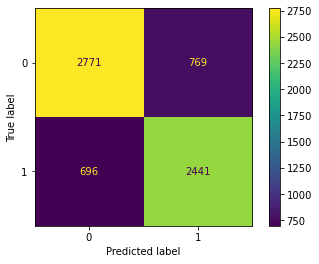

In [127]:
plot_confusion_matrix(best_model_seasonal, X_test, y_test.seasonal_vaccine)  
plt.show();

In [85]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

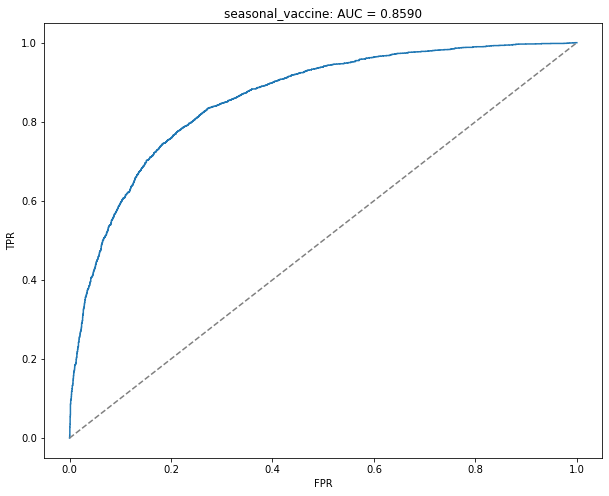

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    best_pred_seasonal, 
    'seasonal_vaccine',
    ax=ax
)

# Combined Score

In [129]:
roc_auc_score(y_test, np.hstack((best_pred_h1n1, best_pred_seasonal)))

0.8646246832957118

# Training on Full Dataset

In [131]:
test = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

### Seasonal Vaccine

In [158]:
final_model_se.fit(train, labels.seasonal_vaccine)

In [159]:
final_se = final_model_se.predict_proba(test)

In [160]:
final_se = final_se[:,1].reshape(-1,1)

### H1N1 Vaccine

In [174]:
best_model_h1n1.fit(train, labels.h1n1_vaccine)

In [175]:
final_h1 = best_model_h1n1.predict_proba(test)

In [176]:
final_h1 = final_h1[:,1].reshape(-1,1)

In [177]:
final_h1

array([[0.25053203],
       [0.1142332 ],
       [0.45748366],
       ...,
       [0.35376134],
       [0.04398293],
       [0.83337339]])

### For competition use

In [164]:
submission_df = pd.read_csv('data/submission_format.csv', index_col='respondent_id')

In [165]:
np.testing.assert_array_equal(test.index.values, submission_df.index.values)

In [166]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
...,...,...
53410,0.5,0.7
53411,0.5,0.7
53412,0.5,0.7


In [167]:
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.250532,0.273941
26708,0.114233,0.035429
26709,0.457484,0.764687
26710,0.824761,0.902444
26711,0.524087,0.508311


In [151]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'./{date}submssion_catboost_optuna.csv', index=True)

In [156]:
import pickle
filepath = 'data/models/Catboost_Optuna/h1n1/model_1.pickl'
pickle.dump(best_model_h1n1, open(filepath, 'wb'))

In [157]:
filepath = 'data/models/Catboost_Optuna/seasonal/model_1.pickl'
pickle.dump(best_model_seasonal, open(filepath, 'wb'))